In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz
import time
from scipy import stats
import itertools
from itertools import combinations
import random
import copy
import math

sys.path.append("../../wave_cluster")
import wave_cluster as wc
%load_ext autoreload
%autoreload 2

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Import data

In [3]:
# Import indexing and related demographic data
index = pd.read_csv("../data/index.csv", index_col = 0)
demographics = pd.read_csv("../data/demographics.csv", index_col = 0)

# US state-level daily case data (# new cases every day)
# Dropping the first 39 timestamps during which reporting practices were still being developed
# and dropping a few of the territories with irregular data
data = pd.read_csv("../data/us_state_daily.csv", index_col = 0)
data = data.iloc[39:,:]
dr = ['US_VI', 'US_MP', 'US_GU', 'US_AS', 'US_DC']
data = data.drop(dr, axis = 1)


# Normalization of each location's time-series to be cases per 100,000 persons (typical in the literature)
population = demographics.loc[data.columns,"population"]
norm_data = data.apply(lambda x: x/population[x.name])
data = norm_data * 100000 # cases per 100,000


# Windowed average smoothing of each time-series 
# Using 7 day average with 3 days in front and behind burrent time-stamp
front = 7
back = 7

# Double averaging procedure (gets rid of sharp fluctuations)
smooth_data = wc.window_average(data.to_numpy(), front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smoothed_index = data.index[front*3:-back*3]
data = pd.DataFrame(smooth_data, index = smoothed_index, columns = data.columns)

# remove any negative entries (reporting errors still present after smoothing)
data[data < 0] = 0

data.index = pd.to_datetime(data.index)
locations = data.columns

In [12]:
# Geographic information -- containing coordinates for each state's center of population
state_centers = pd.read_csv("../data/state_centers.csv", index_col = 0)
state_centers_dict = {i: np.array(state_centers.loc[state_centers.STNAME == i].iloc[:,1:]).flatten() for i in state_centers.STNAME.values}

# Government response / containment health data
containment_health = pd.read_csv('../data/state_containment_health.csv', index_col = 0)

sir_cuts = pd.read_csv('../../batch3/state/data/sir_cuts.csv', index_col = 0)
unimodal_cuts = pd.read_csv("../../batch3/state/data/unimodal_cuts.csv", index_col = 0)
unimodal_cuts = unimodal_cuts.iloc[::2,:]
wavefinder_cuts = pd.read_csv("../../batch3/state/data/wav_cuts.csv", index_col = 0)

D_sir = load_npz('../../batch3/state/data/sir_pairwise.npz')
D_uni = load_npz('../../batch3/state/data/unimodal_pairwise.npz')
D_wav = load_npz('../../batch3/state/data/wav_pairwise.npz')

wpool_sir = wc.wave_pool(data, sir_cuts[data.columns])
wpool_uni = wc.wave_pool(data, unimodal_cuts[data.columns])
wpool_wav = wc.wave_pool(data, wavefinder_cuts[data.columns])


def miles_dist(loc1, loc2):
    loc1 = loc1[:loc1.rfind('_')]
    loc2 = loc2[:loc2.rfind('_')]
    x_loc = state_centers_dict[loc1]
    y_loc = state_centers_dict[loc2]
    return wc.haversine(x_loc, y_loc)


D_uni_miles = wc.pairwise_from_pool(wpool_uni, miles_dist)
D_sir_miles = wc.pairwise_from_pool(wpool_wav, miles_dist)
D_wav_miles = wc.pairwise_from_pool(wpool_sir, miles_dist)

In [4]:
'''
global_vec = data.mean(axis = 1).to_numpy()
max_segments = 10
segment_size = 30
threshold = 0.005
increasing_kmodal_error, decreasing_kmodal_error = wc.compute_kmodal_error_table(global_vec, segment_size = 1, cpu_count = 3)
dp = wc.dynamic_segment(increasing_kmodal_error, segments = 2*max_segments, segment_size = segment_size, error_table2 = decreasing_kmodal_error)
dp.fill_table()

def unimodal_error(cuts):
    errors,uni_wave = wc.unimodal_fit(global_vec).generate(cuts)
    rel_error = np.linalg.norm(global_vec - uni_wave)/np.linalg.norm(global_vec)
    return rel_error

rels = dp.tester(np.array(range(2,max_segments))*2, unimodal_error)

chosen_idx = wc.elbow(rels, threshold)
chosen_segs = list(range(2,max_segments))[chosen_idx]    
dp.backtrack(2*chosen_segs)
errors,uni_wave = wc.unimodal_fit(global_vec).generate(dp.cuts)

global_wave = uni_wave
global_cuts = dp.cuts

cuts = global_cuts[::2]
time_centers = np.floor([np.median(range(cuts[i], cuts[i+1])) for i in range(len(cuts) - 1)])
'''

'\nglobal_vec = data.mean(axis = 1).to_numpy()\nmax_segments = 10\nsegment_size = 30\nthreshold = 0.005\nincreasing_kmodal_error, decreasing_kmodal_error = wc.compute_kmodal_error_table(global_vec, segment_size = 1, cpu_count = 3)\ndp = wc.dynamic_segment(increasing_kmodal_error, segments = 2*max_segments, segment_size = segment_size, error_table2 = decreasing_kmodal_error)\ndp.fill_table()\n\ndef unimodal_error(cuts):\n    errors,uni_wave = wc.unimodal_fit(global_vec).generate(cuts)\n    rel_error = np.linalg.norm(global_vec - uni_wave)/np.linalg.norm(global_vec)\n    return rel_error\n\nrels = dp.tester(np.array(range(2,max_segments))*2, unimodal_error)\n\nchosen_idx = wc.elbow(rels, threshold)\nchosen_segs = list(range(2,max_segments))[chosen_idx]    \ndp.backtrack(2*chosen_segs)\nerrors,uni_wave = wc.unimodal_fit(global_vec).generate(dp.cuts)\n\nglobal_wave = uni_wave\nglobal_cuts = dp.cuts\n\ncuts = global_cuts[::2]\ntime_centers = np.floor([np.median(range(cuts[i], cuts[i+1])) fo

### Cluster visualization

In [5]:
# https://davidmathlogic.com/colorblind/
#https://colorbrewer2.org/#type=qualitative&scheme=Set3&n=4
pd.set_option('mode.chained_assignment', None)

smap1 = sns.color_palette("tab20b", 30)
cmap1 = LinearSegmentedColormap.from_list('mymap1', smap1, N=20)

smap2 = sns.color_palette("tab20b", 19)[2:]
cmap2 = LinearSegmentedColormap.from_list('mymap2', smap2, N=4)

# json file with geographic info for each state -- required for graphing
state_map = gp.read_file("../../data/visualization/tl_rd22_us_state/tl_rd22_us_state.shp")
sl = ['United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands', 'Guam', 'American Samoa'] 
      #'Hawaii', 'Alaska', 'Puerto Rico']
state_map = state_map.drop(state_map.loc[state_map.NAME.isin(sl)].index, axis = 0)
state_map.index = range(len(state_map))

In [6]:
adjusts = {'Hawaii': [40,2.5,0.75],'Puerto Rico': [-5,3,1.5], 'Alaska': [-95,-15,0.25]}

for a in adjusts.keys():
    g = state_map.loc[state_map.NAME == a]
    tr = adjusts[a]
    g['geometry'] = g['geometry'].apply(lambda x:shapely.affinity.scale(x, xfact=tr[2], yfact=tr[2]))
    g['geometry'] = g['geometry'].apply(lambda x:shapely.affinity.translate(x, xoff=tr[0], yoff=tr[1]))
    state_map.loc[state_map.NAME == a] = g

(20.0, 52.0)

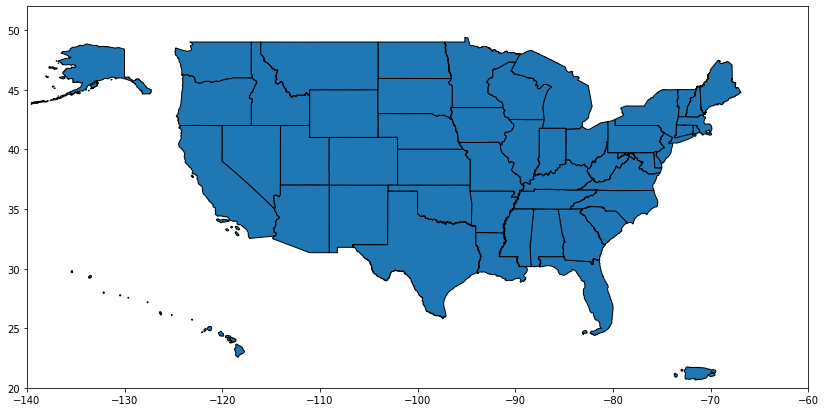

In [7]:
fig,ax = plt.subplots(figsize = (14,8))
state_map.plot(ax = ax, edgecolor="black")
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

In [8]:
translator = {'US_AK': 'Alaska', 'US_AL':'Alabama', 'US_AR':'Arkansas', 'US_AZ':'Arizona', 'US_CA':'California',
             'US_CO':'Colorado', 'US_CT':'Connecticut', 'US_DC':'District of Columbia', 'US_DE':'Delaware', 
             'US_FL':'Florida', 'US_GA':'Georgia', 'US_HI':'Hawaii', 'US_IA': 'Iowa', 'US_ID':'Idaho',
             'US_IL':'Illinois', 'US_IN':'Indiana', 'US_KS':'Kansas', 'US_KY':'Kentucky', 'US_LA':'Louisiana',
             'US_MA':'Massachusetts', 'US_MD':'Maryland', 'US_ME':'Maine', 'US_MI':'Michigan', 'US_MN':'Minnesota',
             'US_MO':'Missouri', 'US_MS':'Mississippi', 'US_MT':'Montana', 'US_NC':'North Carolina', 'US_ND':'North Dakota',
             'US_NE':'Nebraska', 'US_NH':'New Hampshire', 'US_NJ':'New Jersey', 'US_NM':'New Mexico', 'US_NV':'Nevada',
             'US_NY':'New York', 'US_OH':'Ohio', 'US_OK':'Oklahoma', 'US_OR':'Oregon', 'US_PA':'Pennsylvania', 
             'US_PR':'Puerto Rico', 'US_RI':'Rhode Island', 'US_SC':'South Carolina', 'US_SD':'South Dakota',
             'US_TN':'Tennessee', 'US_TX':'Texas', 'US_UT':'Utah', 'US_VA':'Virginia', 'US_VT':'Vermont', 'US_WA':'Washington',
             'US_WI':'Wisconsin', 'US_WV':'West Virginia', 'US_WY':'Wyoming'}

## Segmentation

In [9]:
location = 'US_NY'
sir_segment = sir_cuts.loc[:,location].to_numpy()
sir_segment = sir_segment[~np.isnan(sir_segment)]
unimodal_segment = unimodal_cuts.loc[:,location].to_numpy()
unimodal_segment = unimodal_segment[~np.isnan(unimodal_segment)]
wav_segment = wavefinder_cuts.loc[:,location].to_numpy()
wav_segment = wav_segment[~np.isnan(wav_segment)]

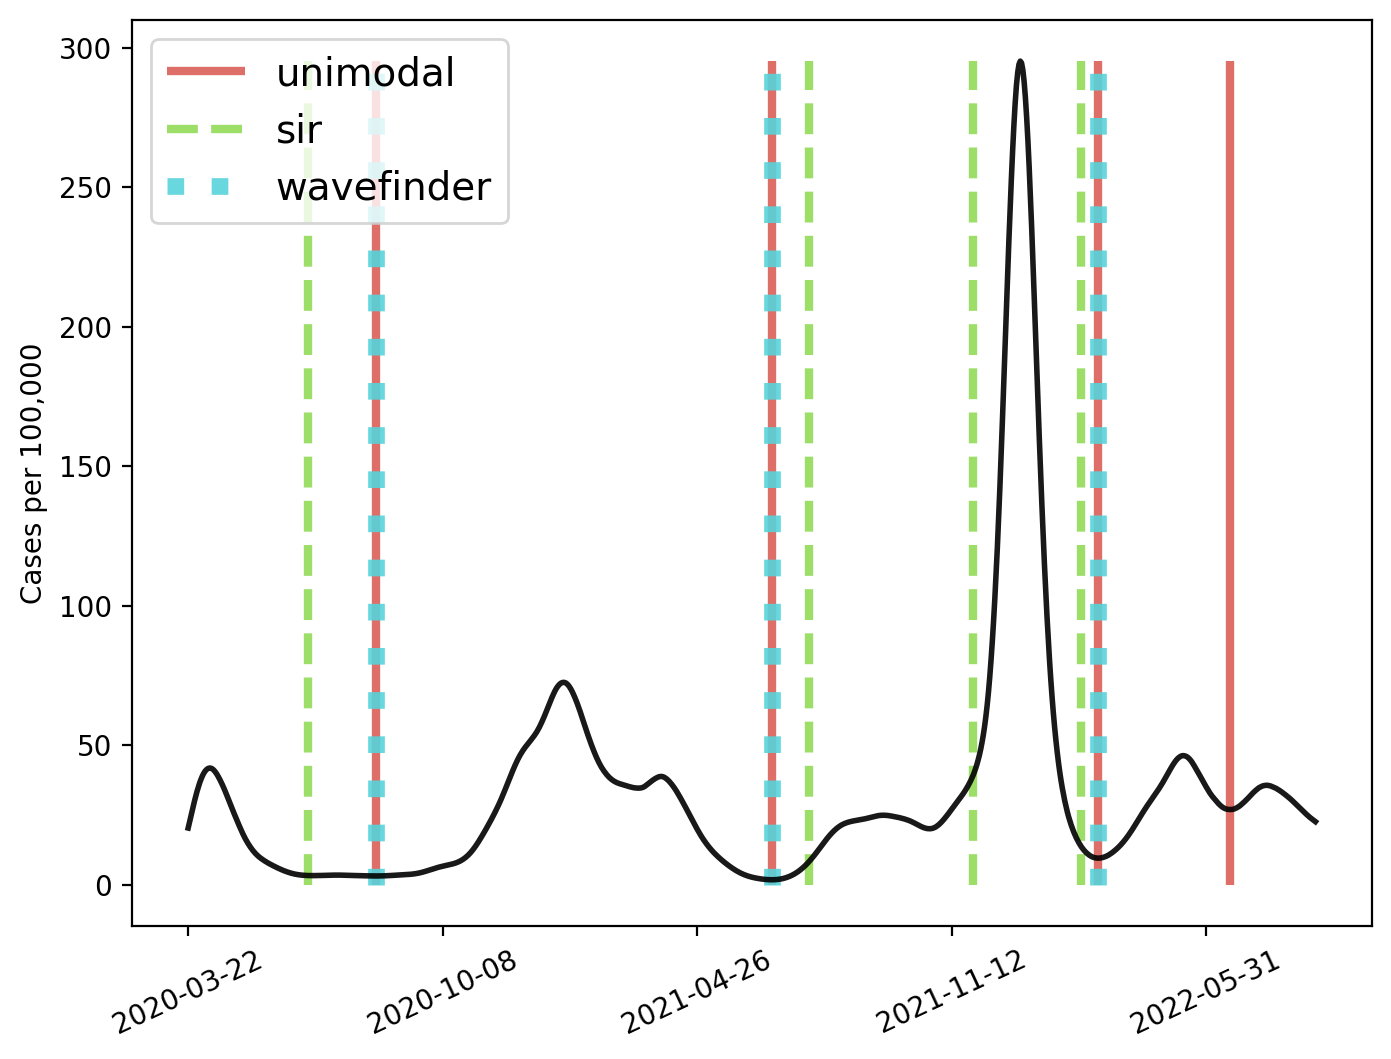

In [10]:
fig,ax = plt.subplots(1,1,figsize = (8,6), dpi = 200)
ax.plot(data.loc[:,location].to_numpy(), color = 'k', alpha = 0.9, linewidth = 2)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})


for c in range(1,len(unimodal_segment)-1):
    if c == 1:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, label = 'unimodal', linewidth = 3)
    else:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, linewidth = 3)
        
        
for c in range(1,len(sir_segment)-1):
    if c == 1:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, label = 'sir', linewidth = 3)
    else:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, linewidth = 3)
        
        

for c in range(1,len(wav_segment)-1):
    if c == 1:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, label = 'wavefinder', linewidth = 6)
    else:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, linewidth = 6)
        
plt.xticks(ticks=[0, 200, 400, 600, 800], labels=[str(data.index[0])[:10], str(data.index[200])[:10], str(data.index[400])[:10], 
                                                  str(data.index[600])[:10], str(data.index[800])[:10]])

plt.ylabel('Cases per 100,000')
plt.xticks(rotation=25) 
plt.legend()

In [24]:
disagreements1 = wc.compute_disagreements(data.columns, range(data.shape[0]), sir_cuts, unimodal_cuts)
disagreements2 = wc.compute_disagreements(data.columns, range(data.shape[0]), wavefinder_cuts, unimodal_cuts)
disagreements3 = wc.compute_disagreements(data.columns, range(data.shape[0]), sir_cuts, wavefinder_cuts)

In [16]:
# random segments:
def get_random_segments():
    max_segments = 10
    segment_size = 60

    rand_cuts = np.zeros((max_segments + 1, len(locations)))

    for l in range(len(locations)):
        loc = locations[l]
        vec = data.loc[:,loc].to_numpy()

        ucuts = unimodal_cuts.loc[:,loc].to_numpy()
        chosen_segs = int((len(ucuts[~np.isnan(ucuts)]) - 1))
        
        rand_seg = wc.random_segment(vec, chosen_segs, segment_size)
        rcuts = rand_seg.generate()

        rand_cuts[:len(rcuts),l] = rcuts
        

    rand_cuts = pd.DataFrame(rand_cuts, columns = locations)
    rand_cuts.replace(0, np.nan, inplace=True)
    rand_cuts.iloc[0,:] = np.zeros(rand_cuts.shape[1])
    return rand_cuts

In [20]:
# average disagreements for rand cuts
samples = 10000
disagreements4 = np.zeros((samples, len(locations)))

for s in range(samples):
    rand_cuts = get_random_segments()
    disagreements4[s,:] = wc.compute_disagreements(data.columns, range(data.shape[0]), rand_cuts, unimodal_cuts)
    
avg_disagreements = np.mean(disagreements4, axis = 0)

In [30]:
std_disagreements = np.std(disagreements4, axis = 0)

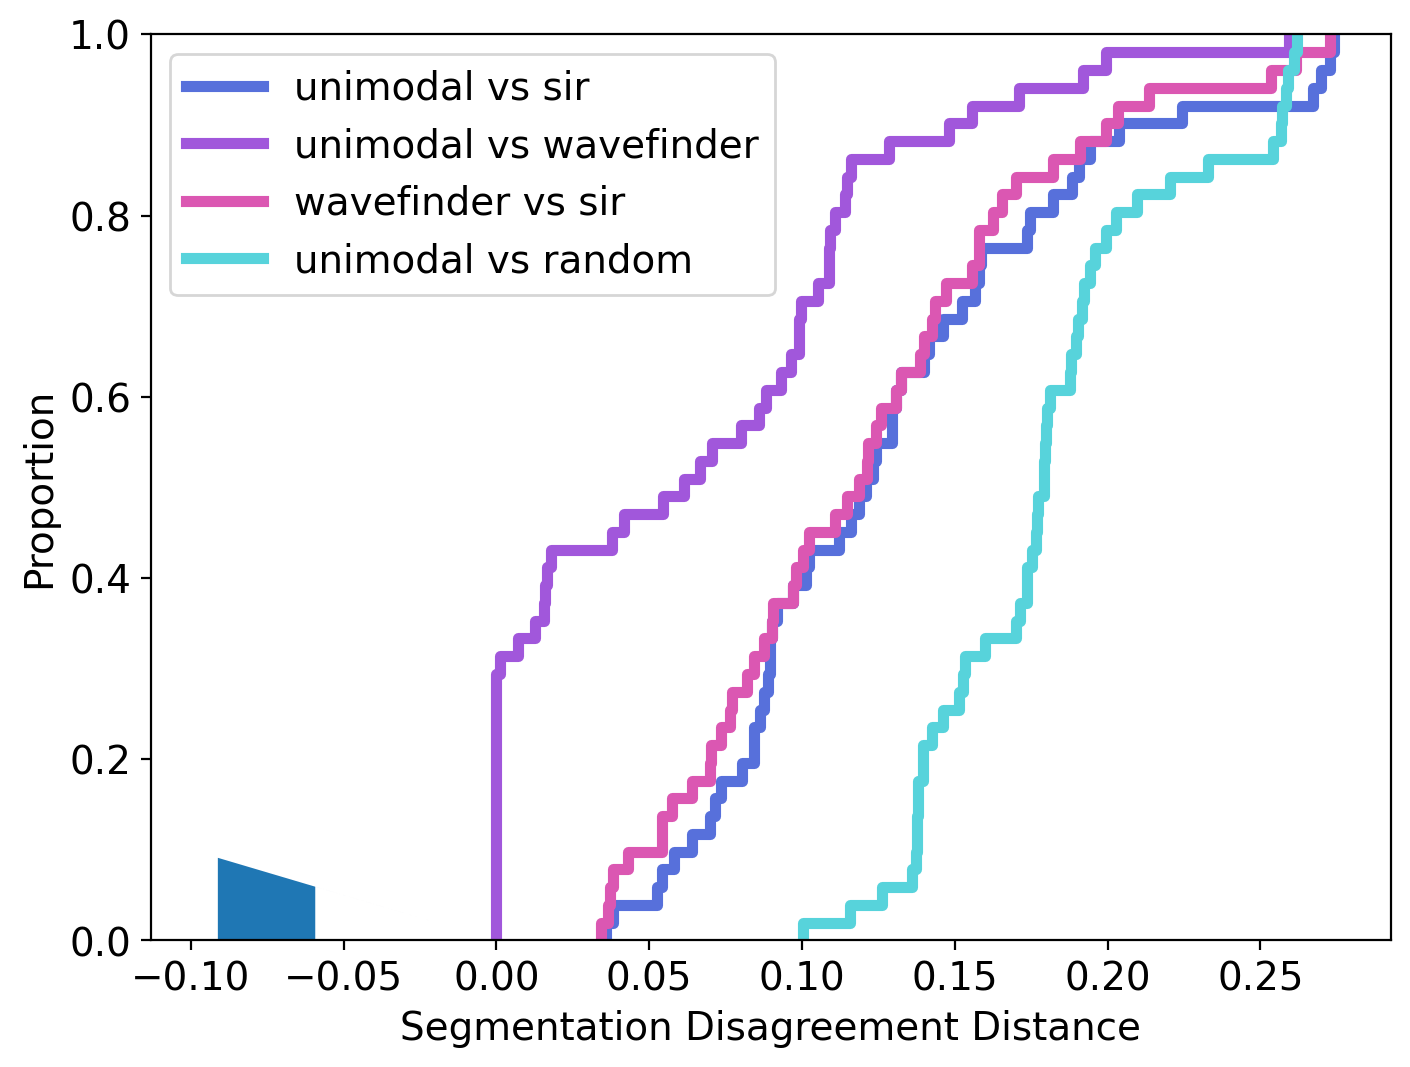

In [33]:
fig,ax = plt.subplots(figsize = (8,6), dpi = 200)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})

sns.ecdfplot(disagreements1, color = pal[5], linewidth = 4, stat = 'proportion', label = 'unimodal vs sir')
#sns.ecdfplot(disagreements1, color = pal[2], linewidth = 4, stat = 'proportion', linestyle = '--', label = 'sir')

sns.ecdfplot(disagreements2, color = pal[6], linewidth = 4, stat = 'proportion', label = 'unimodal vs wavefinder')
#sns.ecdfplot(disagreements2, color = pal[5], linewidth = 4, stat = 'proportion', linestyle = '--', label = 'wavefinder')

sns.ecdfplot(disagreements3, color = pal[7], linewidth = 4, stat = 'proportion',linestyle='-', label = 'wavefinder vs sir')

cc = sns.ecdfplot(avg_disagreements, color = pal[4], linewidth = 4, stat = 'proportion',linestyle='-', label = 'unimodal vs random')
#ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
#sns.ecdfplot(disagreements3, color = pal[5], linewidth = 4, stat = 'proportion', linestyle = '--', label = 'wavefinder')

#sns.ecdfplot(disagreements2, color = pal[2], linewidth = 4, label = 'unimodal vs wavefinder', stat = 'proportion')
#sns.ecdfplot(disagreements3, color = pal[4], linewidth = 4, label = 'sir vs wavefinder', stat = 'proportion')

#reflected_data1 = np.concatenate([disagreements1, -disagreements1])
#sns.kdeplot(reflected_data1, bw_adjust=0.5, color = pal[0], linewidth = 3, fill = True, label = 'unimodal vs sir')
#sns.kdeplot(disagreements2, bw_adjust=1, color = pal[2], linewidth = 3, fill = True, label = 'unimodal vs wavefinder')
#sns.kdeplot(disagreements3, bw_adjust=1, color = pal[4], linewidth = 3, fill = True, label = 'sir vs wavefinder')
ax.set_xlabel('Segmentation Disagreement Distance')

#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend([(handles[0], handles[1]), (handles[2], handles[3]), (handles[4], handles[5])], 
#           ["unimodal vs sir", "unimodal vs wavefinder", "wavefinder vs sir"],
#           handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')
plt.legend()
#plt.xlim(0,1)

In [32]:
cc.fill_between(-std_disagreements, std_disagreements)

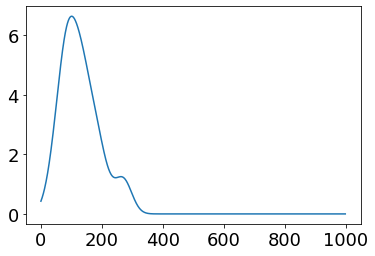

In [34]:
plt.plot(pdf_values1)

In [17]:
#fig,ax = plt.subplots(figsize = (14,8), dpi = 200)
#ax.bar(data.columns, disagreements0, alpha = 0.5, label = 'before')
#ax.bar(data.columns, disagreements, alpha = 0.5, label = 'with unimodal # segments')
#ax.set_xlabel("location")
#ax.set_ylabel('Relative disagreement distance')
#ax.tick_params(axis='x', labelrotation=65)
#plt.legend()

## Cluster Data with Parameter changes

In [18]:
# Next we've pre-computed some stats on each of our clustering methods at different parameter values
# These should give us an idea for which parameter values we might be interested in
param_info = pd.read_csv('../../batch3/state/data/parameter_info.csv', index_col = 0)
param_info.overlap = np.round(param_info.overlap, 2)

# These are all of the parameter values being tested (all combinations possible)
#percent_try = np.round(np.linspace(0.5,1,11),2)
#threshold_try = list(range(20,51))
#percent_try = np.round(np.linspace(0.5,1,11),2)
#threshold_try = range(10,61)
percent_try = np.round(np.linspace(0.3,1,15),2)
threshold_try = np.round(np.linspace(0,0.4,21),2)

In [55]:
# Choose a specific clustering method to analyze its results
method = 'uni'
method_param_info = param_info.loc[param_info.method == method]
pcombs = method_param_info.loc[:,['overlap', 'threshold']].value_counts().index
method_param_averages = []
samps = method_param_info['sample'].value_counts().index

for p in pcombs:
    ploc = method_param_info[(method_param_info['overlap'] == p[0]) & (method_param_info['threshold'] == p[1])]
    
    if len(samps) == 0:
        #ploc = ploc.loc[ploc.cluster_size >= 2]
        method_param_averages += [ploc.mean().to_list()[1:]]
    else:
        savg = []
        for s in samps:
            psloc = ploc[ploc['sample'] == s]
            psloc = psloc.loc[psloc.cluster_size >= 2]
            savg += [psloc.mean().to_list()[1:]]

        method_param_averages += [list(np.mean(savg, axis = 0))]
        
    
method_param_averages = pd.DataFrame(method_param_averages, columns = method_param_info.columns[2:])
method_param_averages = method_param_averages.drop(['cluster'], axis = 1)
method_param_averages.overlap = np.round(method_param_averages.overlap, 2)
method_param_averages.threshold = np.round(method_param_averages.threshold, 2)

In [56]:
var = 'silhouette_score'
param = method_param_averages
param_matrix = np.zeros((len(threshold_try), len(percent_try)))
for t in range(len(threshold_try)):
    thrsh = param.loc[param.threshold == threshold_try[t]]
    for p in range(len(percent_try)):
        try:
            prcnt = thrsh.loc[thrsh.overlap == percent_try[p]]
            param_matrix[t,p] = prcnt[var]
        except:
            print((p,t))

Text(0.5, 1.0, 'silhouette score')

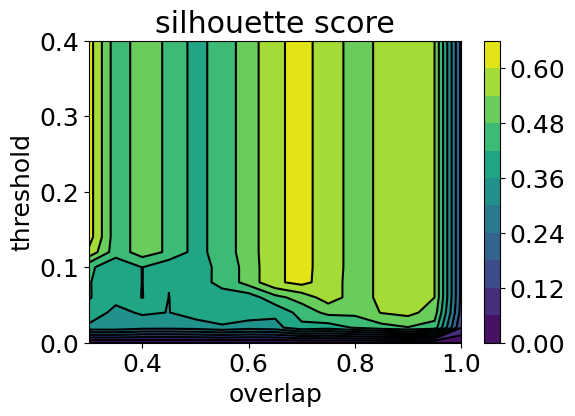

In [57]:
fig, ax = plt.subplots(dpi = 100)
cs = ax.contourf(percent_try, threshold_try, param_matrix, levels = 10)
ax.contour(cs, colors='k')
cbar = fig.colorbar(cs)
ax.set_xlabel('overlap')
ax.set_ylabel('threshold')
ax.set_title('silhouette score')

In [58]:
param.iloc[param.silhouette_score.idxmax(),:]

overlap               3.000000e-01
threshold             3.400000e-01
cluster_size          1.712500e+01
cost                  4.314024e-02
silhouette_score      6.268144e-01
total_points          2.827312e+03
explained_variance    4.121348e+06
diameter_miles        1.031267e+03
diameter_density      2.222581e+02
containment_health    8.337568e+00
avg_infections        3.071379e+01
Name: 301, dtype: float64

In [59]:
param.loc[param.overlap == 0.7]

,overlap,threshold,cluster_size,cost,silhouette_score,total_points,explained_variance,diameter_miles,diameter_density,containment_health,avg_infections
6,0.7,0.00,1.000000,0.000000,0.000000,165.098540,2.406626e+05,0.000000,0.000000,0.000000,32.311633
93,0.7,0.02,4.029412,0.008812,0.404643,665.250000,9.697289e+05,666.163886,159.980801,4.041884,27.304275
126,0.7,0.04,5.829787,0.014089,0.443046,962.489362,1.403012e+06,717.679376,181.910627,4.553385,30.284771
149,0.7,0.06,7.210526,0.020459,0.505802,1190.447368,1.735304e+06,838.202874,225.428650,5.383203,31.806700
152,0.7,0.24,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153
154,0.7,0.10,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153
155,0.7,0.12,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153
156,0.7,0.16,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153
157,0.7,0.18,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153
158,0.7,0.20,7.405405,0.019914,0.618265,1222.621622,1.782204e+06,807.552418,224.199784,5.405091,31.740153


## Clique Clustering

Now I'll perform an actual clustering with parameter values overlap = 80% and cost threshold = 30. We chose these parameter values as a good tradeoff between having low cost while still retaining larger average cluster size. Regardless, we'll show that many of the clusters we find are robust to parameter choices

In [13]:
overlap = 0.7
threshold = 0.08
wpool = wpool_uni
D = D_uni
edge_list = wc.overlap_graph(overlap, wpool)
cliquer = wc.clique_cluster(D, edge_list, linkage = 'complete', threshold = threshold)
cliquer.cluster(1)

In [16]:
# Set up the results for analysis
#cluster_analysis = wc.cluster_analyze(D, segment_pool = wpool, clustering = cliquer.C)
cluster_analysis = wc.cluster_analyze(cliquer, segment_pool = wpool)
clustering = cluster_analysis.clustering
labels = cluster_analysis.labels

cluster_data = wc.auxiliary_info(cliquer, wpool, [D_uni_miles], containment_health, data)
cluster_data = pd.DataFrame(cluster_data, columns = ['cluster','cluster_size', 'cost','total_points','explained_variance',
                                                     'silhouette', 'geo_silhouette', 
                                                     'containment_health','avg_infections'])
cluster_data_nons = cluster_data.loc[cluster_data.cluster_size > 1]

In [17]:
# Record every wave
cluster_waves = {}
for clust in range(len(cliquer.C)):
    time_overlap_min = -1
    time_overlap_max = np.inf
    data_names = []
    for l in cliquer.C[clust]:
        lname = wpool.key_list[l]
        data_names.append(lname[:5])
        ltimes = wpool.times[lname]
        if ltimes[0] > time_overlap_min:
            time_overlap_min = ltimes[0]
        if ltimes[1] < time_overlap_max:
            time_overlap_max = ltimes[1]
            
        
    cluster_wave_data = data.loc[:, data_names].copy(deep = True)
    
    # changed to see global times!
    cluster_wave_data.iloc[:time_overlap_min,:] = np.nan
    cluster_wave_data.iloc[time_overlap_max:,:] = np.nan
    #cluster_wave_data = cluster_wave_data.iloc[time_overlap_min:time_overlap_max,:]
    cluster_waves[clust] = cluster_wave_data

In [18]:
# Some measures for each cluster:
# Looking for clusters which maximize point/cost ratio or variance/cost ratio

#cluster_data_nons['size_cost'] = cluster_data_nons['cluster_size']/cluster_data_nons['cost']
#cluster_data_nons['miles_size'] = cluster_data_nons['cluster_size']/cluster_data_nons['diameter_miles']
#cluster_data_nons['size_infection'] = cluster_data_nons['cluster_size']*cluster_data_nons['avg_infections']
#cluster_data_nons['infection_contain'] = cluster_data_nons['avg_infections']/cluster_data_nons['containment_health']
cluster_data_nons['point_cost'] = cluster_data_nons['total_points']/cluster_data_nons['cost']
cluster_data_nons['variance_cost'] = cluster_data_nons['explained_variance']/cluster_data_nons['cost']

In [19]:
# Here I greedily select the clusters that cover the most data points and will plot how the total 
# percent of data points covered changes as I select more and more clusters
point_cdf = cluster_data.sort_values(by = 'total_points', ascending = False).total_points.to_numpy()
point_cdf = point_cdf / (data.shape[0]*data.shape[1])

# Likewise I'm also finding the clusters which explain the most amount of variance in the data and will 
# plot how the percent of explained variance changes
var_cdf = cluster_data.sort_values(by = 'explained_variance', ascending = False).explained_variance.to_numpy()
X = data.to_numpy()
X = X - np.mean(X, axis = 0)
#X = X - np.mean(X)
X = X ** 2
var_cdf = var_cdf / np.sum(X)

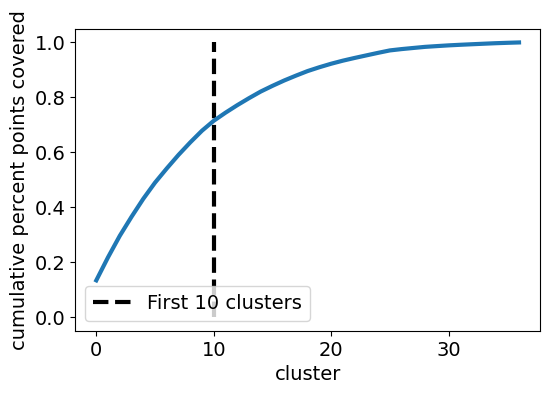

In [20]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(point_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent points covered')
ax.vlines(x = 10, ymin = 0, ymax = np.max(np.cumsum(point_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 10 clusters')
plt.legend()

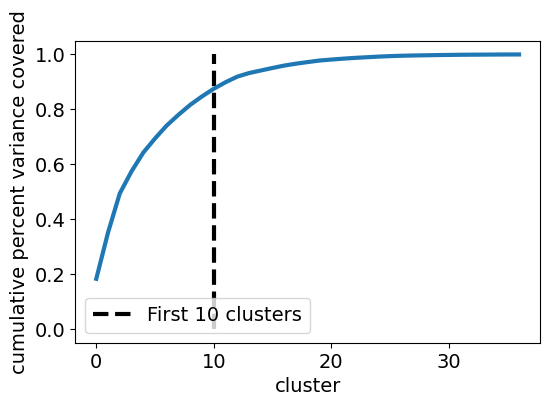

In [21]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(var_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent variance covered')
ax.vlines(x = 10, ymin = 0, ymax = np.max(np.cumsum(var_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 10 clusters')
plt.legend()

In [22]:
cluster_data_nons.sort_values(by = 'point_cost', ascending = False).head(5)

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,containment_health,avg_infections,point_cost,variance_cost
12,12,8,0.009484,3535,3.123230e+06,0.900477,0.913591,39.360500,25.462464,372715.512691,3.293003e+08
18,18,14,0.013400,3802,2.576298e+06,0.627855,0.242802,47.338304,31.981942,283729.984230,1.922602e+08
17,17,9,0.013180,2665,1.836341e+06,0.603660,0.134623,48.237678,26.517023,202201.890980,1.393289e+08
10,10,12,0.008128,1634,1.205840e+07,0.380587,-0.403719,38.525376,73.179992,201021.149988,1.483472e+09
9,9,5,0.006832,1332,4.493499e+06,1.000000,1.000000,40.575493,50.829492,194972.253973,6.577385e+08


In [23]:
cluster_data_nons.sort_values(by = 'variance_cost', ascending = False).head(5)

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,containment_health,avg_infections,point_cost,variance_cost
10,10,12,0.008128,1634,1.205840e+07,0.380587,-0.403719,38.525376,73.179992,201021.149988,1.483472e+09
13,13,7,0.010206,1094,9.388203e+06,0.376727,0.111716,40.986698,82.666685,107191.346674,9.198667e+08
16,16,15,0.012856,2234,1.111282e+07,0.068143,-0.056904,37.972973,62.052478,173768.612600,8.643957e+08
9,9,5,0.006832,1332,4.493499e+06,1.000000,1.000000,40.575493,50.829492,194972.253973,6.577385e+08
20,20,7,0.015354,800,5.302473e+06,0.181386,0.244358,35.293137,76.520226,52105.218979,3.453581e+08


In [24]:
# Now after seeing these we can
# select a cluster for viewing

cluster_select = 19
indices = np.where(labels == cluster_select)[0]
locs = [wpool.key_list[i][:5] for i in indices]
locc = [wpool.key_list[i] for i in indices]

#n_clusters = len(clustering)
#smapn = sns.color_palette("tab20b")[::-1]
#cmapn = LinearSegmentedColormap.from_list('mymapn', smapn, N=n_clusters)
#smapt = [(1,1,1), cmapn(cluster_select)]
#cmapt = LinearSegmentedColormap.from_list('mymapt', smapt, N=2)

sequential_cmap = plt.cm.Blues
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(50, 256)]
custom_cmap = ListedColormap(colors)

global_min, global_max = 0, 100
norm = Normalize(vmin=global_min, vmax=global_max)

(20.0, 52.0)

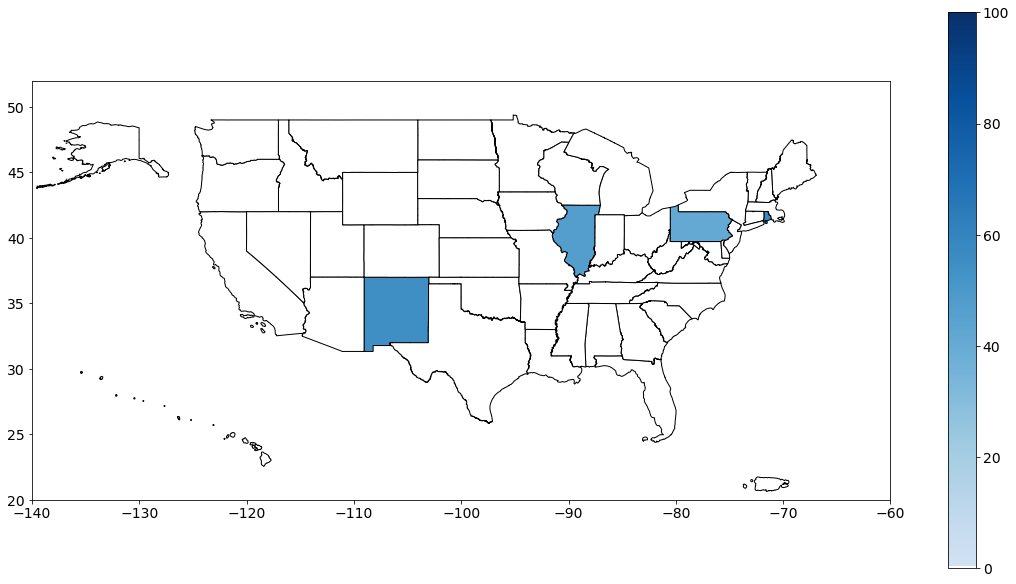

In [25]:
# Here I am coloring each of the states by their containment health government response score
val_col = np.zeros(len(state_map))
for l in locc:
    ind = state_map.loc[state_map.NAME == translator[l[:5]]].index[0]
    #val_col[ind] = cluster_select
    val_col[ind] = containment_health.loc[:,l[:5]][wpool.times[l][0]:wpool.times[l][1]].mean()

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
state_map['val'] = val_col        
state_map.plot(column='val',legend=True, ax = ax, edgecolor = 'black', cmap = custom_cmap, norm = norm)
#ax.set_xlim(-90, -60)
#x.set_ylim(35,52)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

(array([18793., 18809., 18823., 18840., 18854., 18871., 18885., 18901.,
        18915., 18932.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

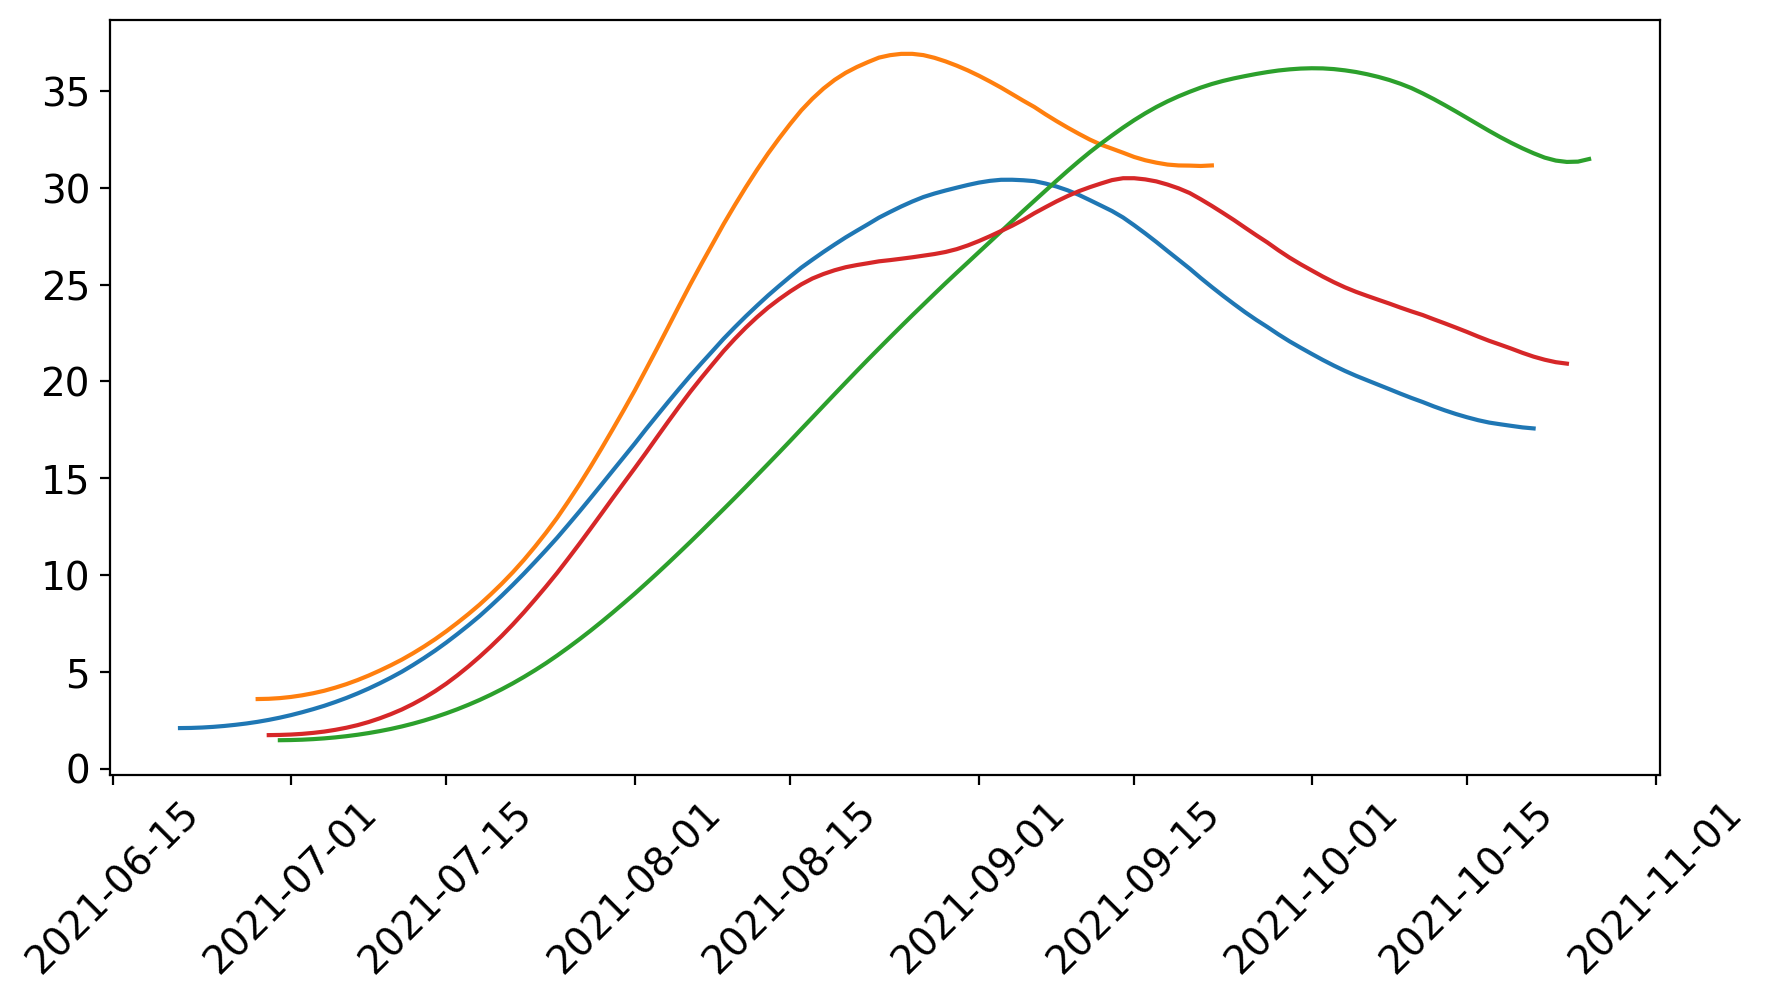

In [26]:
fig, ax = plt.subplots(figsize=(10,5), dpi = 200)

data_vis = data.loc[:,locs].copy(deep = True)

for i in range(len(indices)):
    wname = wpool.key_list[indices[i]]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], label = wname)
    #data_vis.iloc[:t1, i] = np.nan
    #data_vis.iloc[t2:, i] = np.nan
    
#data_vis.plot(ax = ax, legend = True, cmap = 'tab20')
    
plt.xticks(rotation=45)
#plt.legend()

## Clusters with Parameter Changes

In [35]:
# First analyze what happens for different choices of overlap and threshold parameters
# Before we choose a single parameter combo, we just want to make sure that things are robust to 
# parameter choices

# Here, I'm loading in a bunch of pre-computed clusterings for various parameter settings 

overlap_try = np.round(np.linspace(0.3,1,15),2)
threshold_try = np.round(np.linspace(0,0.4,21),2)
params = list(itertools.product(overlap_try, threshold_try))

#uni_param_clusters = pd.read_csv('../../batch2/data/uni_param_clusterings.csv', index_col = 0)
uni_param_clusters = pd.read_csv('../../batch3/data/state/uni_param_clusterings.csv', index_col = 0)

#sir_param_clusters = pd.read_csv('../../batch2/data/sir_param_clusterings.csv', index_col = 0)
sir_param_clusters = pd.read_csv('../../batch3/data/state/sir_param_clusterings.csv', index_col = 0)

#wav_param_clusters = pd.read_csv('../../batch2/data/wav_param_clusterings.csv', index_col = 0)
wav_param_clusters = pd.read_csv('../../batch3/data/state/wav_param_clusterings.csv', index_col = 0)

In [36]:
# Choose a segmentation method to analyze:
wpool = wpool_uni
D = D_uni

In [37]:
# Then I'd like to determine if the cluster is robust to parameter choices
# To do so I'll again look for cliques of locations that show up 
# for different parameter choices. From the set of all cliques 
# I'll look for ones that contain or are contained by the current cluster
cluster_select = 20
indices = np.where(labels == cluster_select)[0]
locs = [wpool.key_list[i][:5] for i in indices]
locc = [wpool.key_list[i] for i in indices]

overlap_try = np.round(np.linspace(0.3,1,15),2)
threshold_try = np.round(np.linspace(0,0.4,21),2)
params = list(itertools.product(overlap_try, threshold_try))

# Looking for a more specific range of parameters
max_overlap = 0.9
min_overlap = 0.6
max_threshold = 0.2
min_threshold = 0.02
idc = [i for i in range(len(params)) if params[i][0] <= max_overlap and params[i][0] >= min_overlap 
                                      and params[i][1] <= max_threshold and params[i][1] >= min_threshold]

uni_max = uni_param_clusters.iloc[idc, :]
column_pairs = list(combinations(uni_param_clusters.columns, 2))
cutoffs = np.linspace(0.1,1,10)[::-1]
cutoff_cliques = []

for cut in cutoffs:
    common_pairs = []
    for cp in column_pairs:
        if len(np.where((uni_max[cp[0]] == uni_max[cp[1]]))[0]) / len(uni_max) >= cut:
            common_pairs.append(cp)

    # find all cliques
    column_graph = nx.from_edgelist(common_pairs)
    cliques = list(nx.find_cliques(column_graph))
    foundc = None
    for cli in cliques:
        # If a found clique is a subclique or otherwise contains the current cluster,
        # record it
        if all(x in locc for x in cli):
            if foundc is None or len(foundc) < len(cli):
                foundc = cli
        if all(x in cli for x in locc):
            if foundc is None or len(foundc) < len(cli):
                foundc = cli
                
    cutoff_cliques.append(foundc)

(20.0, 52.0)

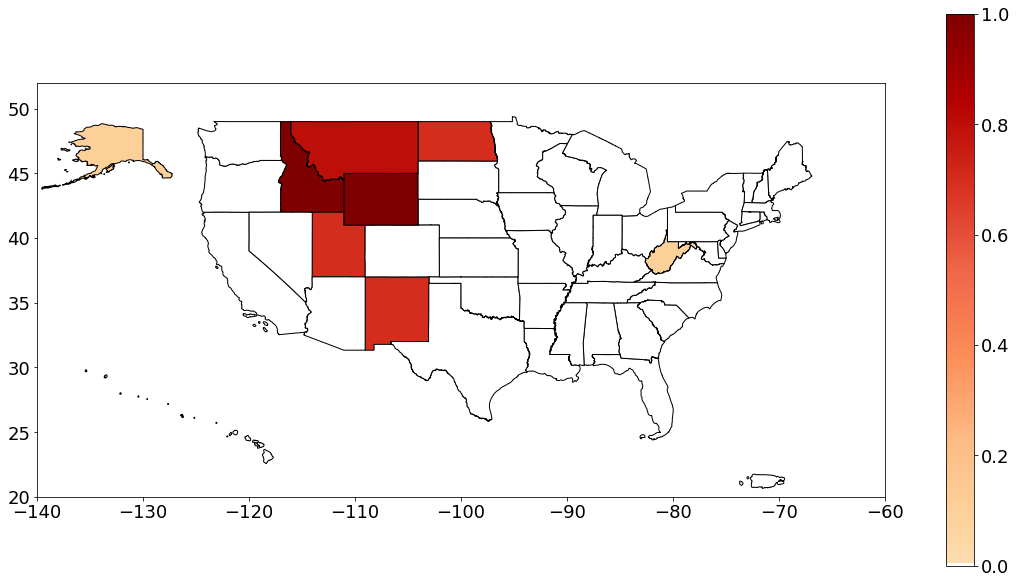

In [38]:
# Now I'll plot a map showing how often each location gets included in 
# the cluster. Also notice that some new locations might show as 
# being included for some percent of the parameter values

sequential_cmap = plt.cm.OrRd
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(50, 256)]  # White plus the blue scale
custom_cmap = ListedColormap(colors)
global_min, global_max = 0, 1
norm = Normalize(vmin=global_min, vmax=global_max)

val_col = np.zeros(len(state_map))
for p in range(len(cutoff_cliques)):
    if cutoff_cliques[p] is not None:
        p_locs = [i[:5] for i in cutoff_cliques[p]]
        p_locc = cutoff_cliques[p]
        for l in p_locc:
            ind = state_map.loc[state_map.NAME == translator[l[:5]]].index[0]
            if val_col[ind] == 0:
                val_col[ind] = cutoffs[p]

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
state_map['val'] = val_col        
state_map.plot(column='val',legend=True, ax = ax, edgecolor = 'black', cmap = custom_cmap, norm = norm)
#ax.set_xlim(-90, -60)
#x.set_ylim(35,52)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

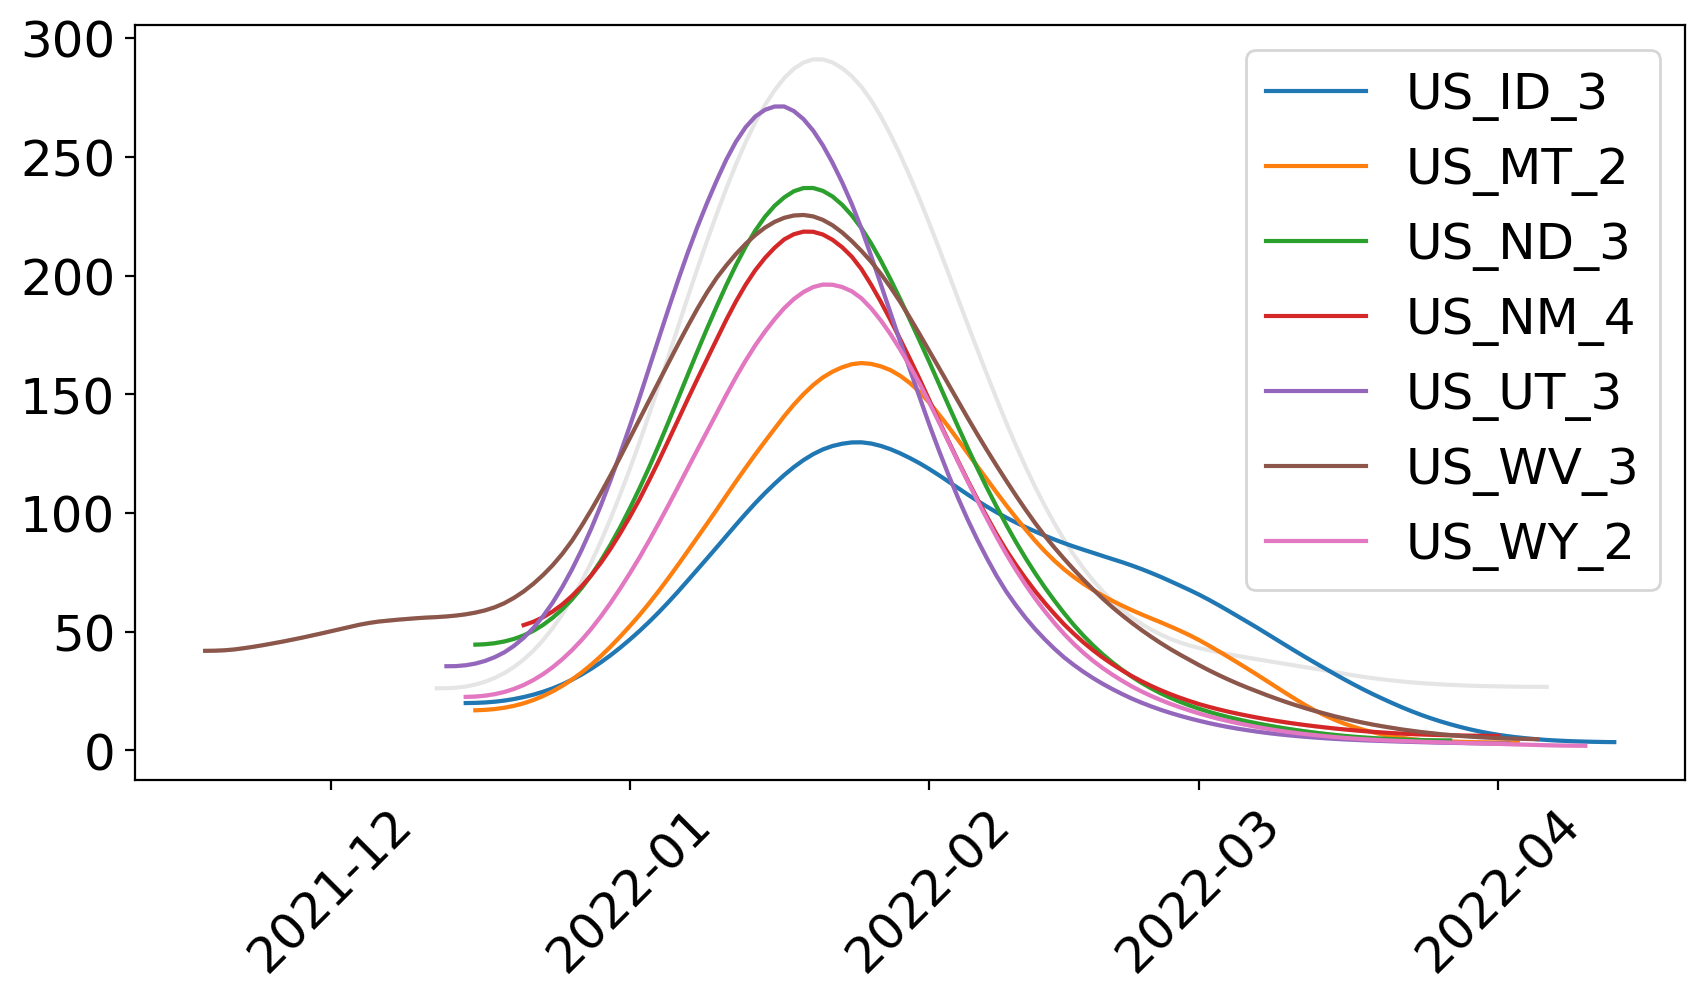

In [39]:
# Plot the waves for all of these locations

fig, ax = plt.subplots(figsize=(10,5), dpi = 200)

unique_elements = set(element for sublist in cutoff_cliques if sublist is not None for element in sublist)
unique_elements_list = list(unique_elements)
clique_locs = [i[:5] for i in unique_elements_list]


for i in range(len(unique_elements)):
    wname = unique_elements_list[i]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], color = 'k', alpha = 0.1)
    

for i in range(len(indices)):
    wname = wpool.key_list[indices[i]]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], label = wname)
    
plt.xticks(rotation=45)
plt.legend()

### Clusters by Time

In [27]:
# Given a time stamp, find all segments which contain it
def get_segments(time, time_frame):
    time_segments = []
    for segment in range(len(wpool.key_list)):
        wname = wpool.key_list[segment]
        wtimes = wpool.times[wname]
        if time >= wtimes[0] and time < wtimes[1]:
            if wtimes[0] >= time_frame[0] and wtimes[1] <= time_frame[1]:
                time_segments.append(segment)
    return time_segments


# Find all clusters which are fully represented by a list of segments,
# I.e. only record a cluster as present if all of its segments are in the input list
def segment_clusters(segments):
    time_segment_clusters = []
    for c in range(len(cliquer.C)):
        cluster = set(cliquer.C[c])
        covered = set()
        for seg in segments:
            if seg in cluster:
                covered = covered.union({seg})
                
        if cluster == covered:
            time_segment_clusters.append(c)
                    
    return time_segment_clusters

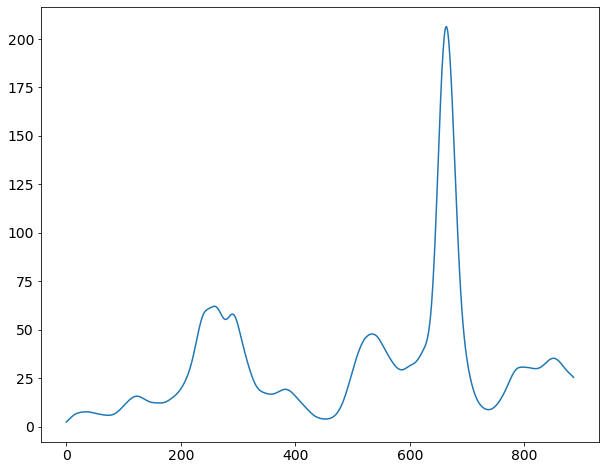

In [28]:
fig,ax = plt.subplots(figsize = (10,8))
ax.plot(data.mean(axis = 1).to_numpy())

In [47]:
# select a time and plot the clusters covered
# 0: (0,250)
# 250: (0, 500)
# 550: (400,700)
# 650: (400, 800)
# 800: (700, 900)

time = 800
time_frame = (700,900)
time_segments = get_segments(time, time_frame)
time_segment_clusters = segment_clusters(time_segments)

locs = [wpool.key_list[i][:5] for i in time_segments]
loccs = [wpool.key_list[i] for i in time_segments]

sequential_cmap = plt.cm.tab20
#if -1 in time_segment_clusters:
#    colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(20)]
#else:
#    colors = [sequential_cmap(i) for i in range(20)]

unique_clusters = np.sort(list(set(time_segment_clusters)))
#colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(len(unique_clusters + 5))]
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(20)]
#colors = [(1, 1, 1)] + [palette[i] for i in range(20)]
custom_cmap = ListedColormap(colors)

#unique_clusters = np.sort(list(set(time_segment_clusters)))
color_indices = np.round(np.linspace(1, len(colors) - 1, len(unique_clusters))).astype(int)
#color_indices = range(len(unique_clusters))
color_dict = {unique_clusters[i]:colors[color_indices[i]] for i in range(len(unique_clusters))}
color_dict[-1] = colors[0]

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/numpy-1.19.5-py3.8-linux-x86_64.egg/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([], [])

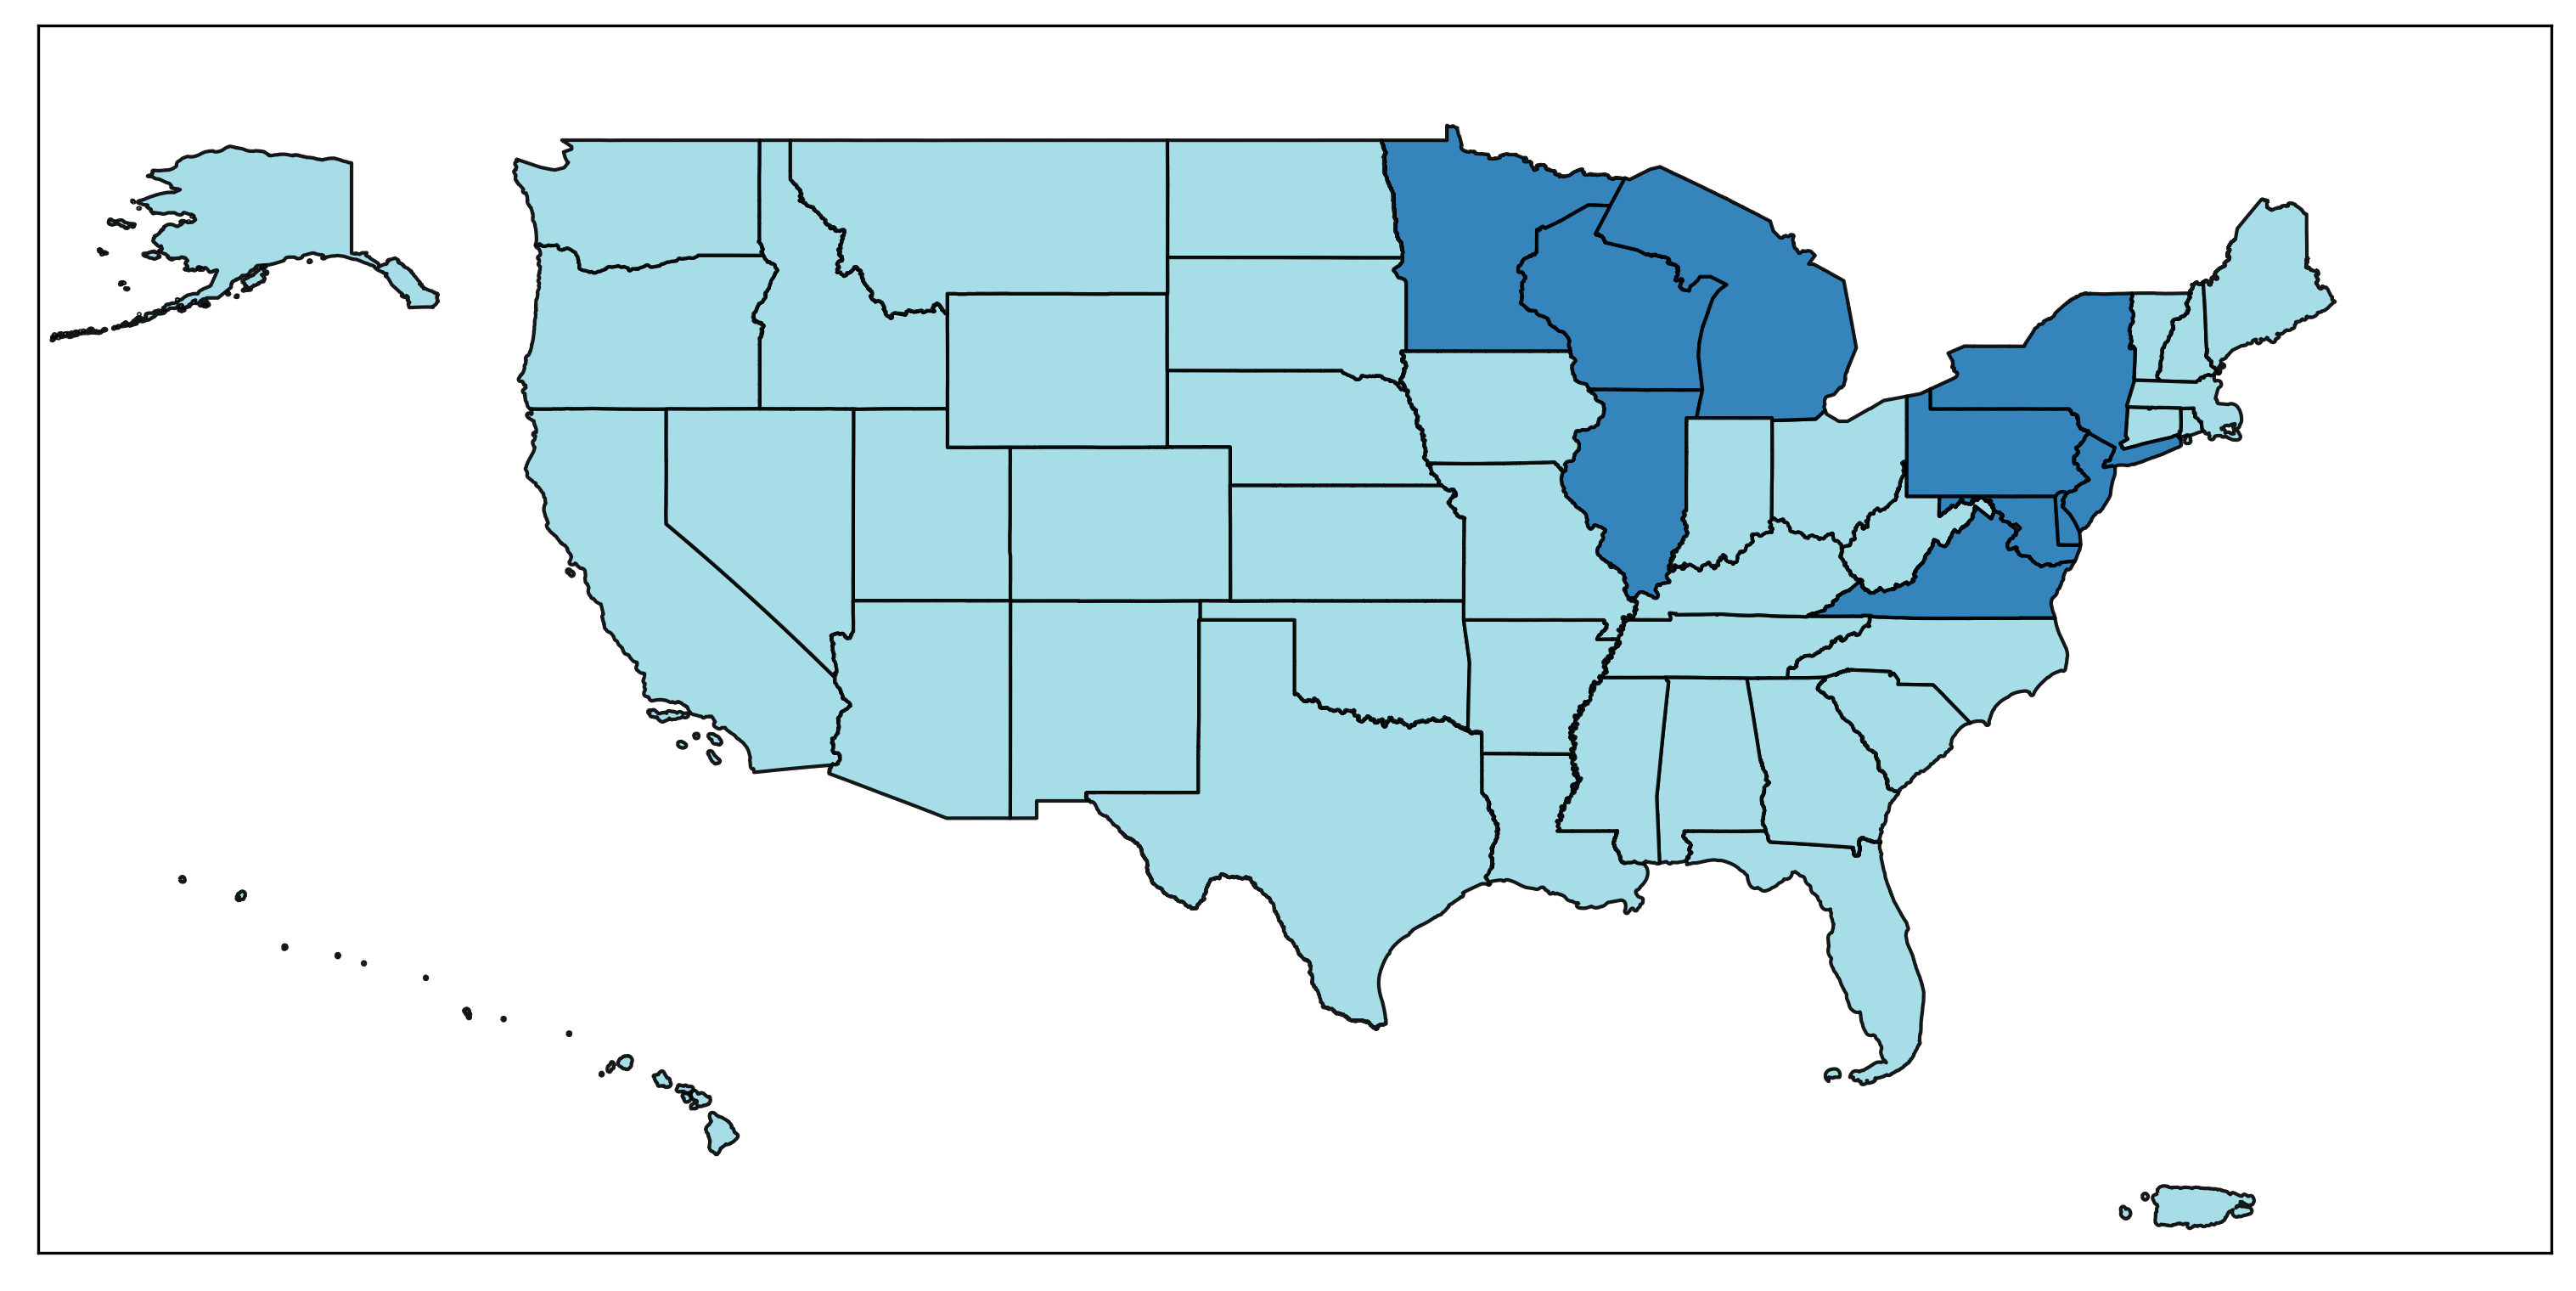

In [48]:
val_col = np.zeros(len(state_map)) - 1
for c in unique_clusters:
    #if len(cliquer.C[c]) > 1:
    for i in cliquer.C[c]:
        location = wpool.key_list[i][:5]
        ind = state_map.loc[state_map.NAME == translator[location]].index[0]
        #val_col[ind] = color_dict[c]
        val_col[ind] = c


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,10), dpi = 300)
state_map['val'] = val_col
state_map['color'] = state_map['val'].map(color_dict)
state_map.plot(color=state_map['color'].to_list() ,legend=False, ax = ax, edgecolor = 'black', alpha = 0.9)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)
plt.xticks([])
plt.yticks([]) 

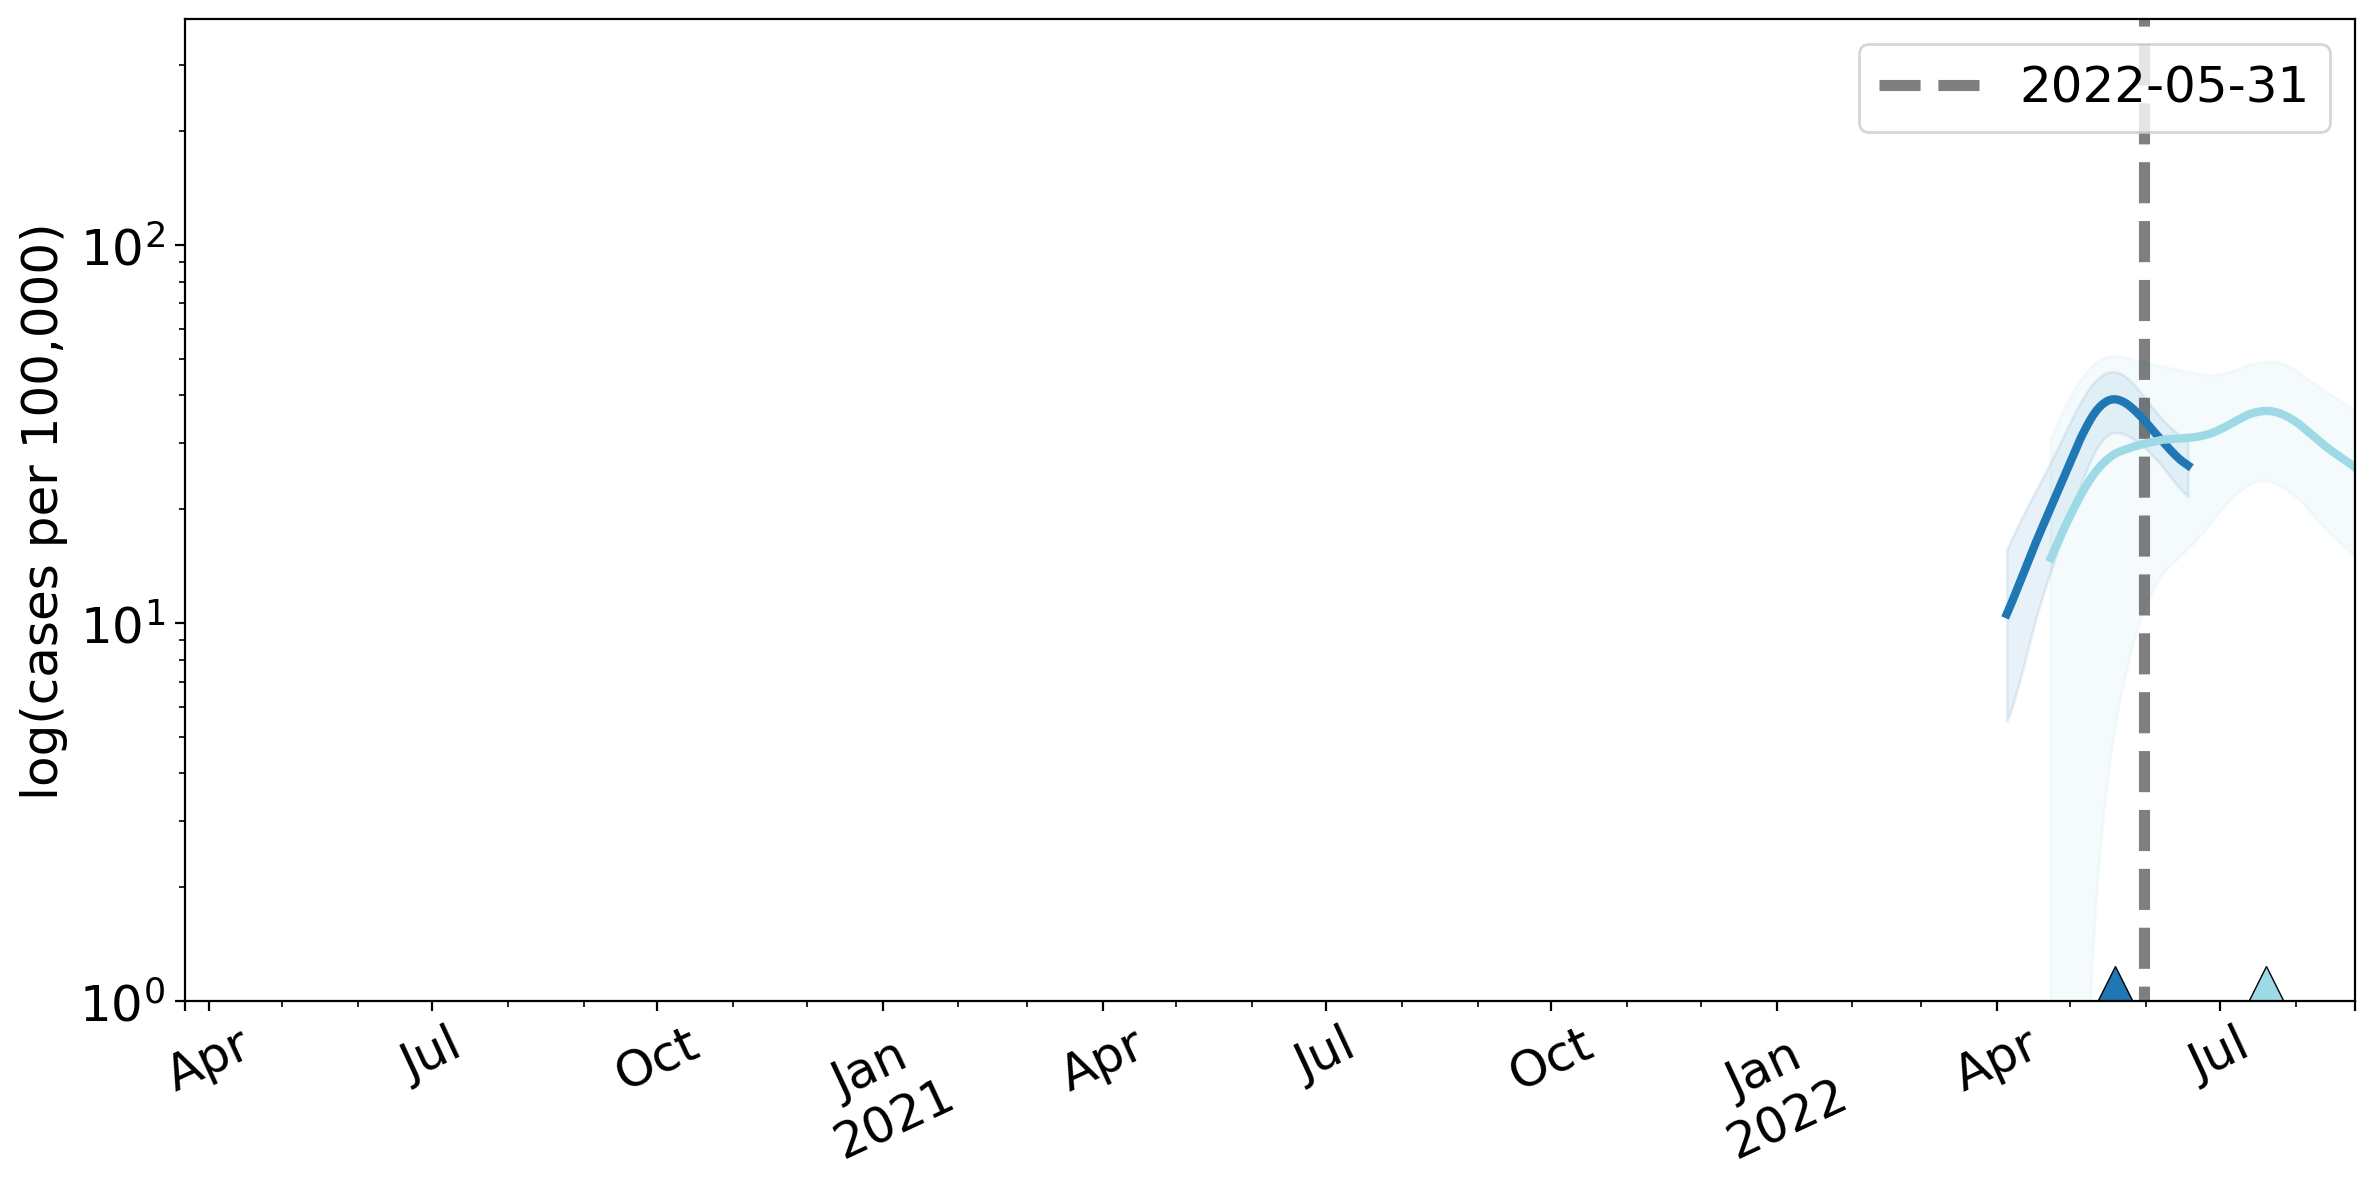

In [49]:
fig,ax = plt.subplots(figsize = (14,6.5), dpi = 200)
plt.rcParams.update({'font.size': 18})
data_max = 0

def maxer(inp):
    return max(inp,1)

for u in unique_clusters:
    #if len(cliquer.C[u]) > 1:
    wvs = cluster_waves[u]
    cluster_color = color_dict[u]
    #cluster_color = color_dict[u]
    x = wvs.index
    #x = data.index
    mean = wvs.mean(axis = 1)
    std = wvs.std(axis = 1)
    
    #vis = [x] 
    #ax.plot(x, mean, c=cluster_color, linewidth = 2)
    mean.plot(c = cluster_color, linewidth = 3, label='_no_legend_')
    ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
    #np.log2(mean).plot(c = cluster_color, linewidth = 3, label='_no_legend_')
    #ax.fill_between(x, np.log2((mean - std).apply(maxer)), np.log2(mean + std), color=cluster_color, alpha=0.1)
    
    max_idx = np.argmax(mean)
    ax.plot(x[max_idx], 1, marker='^', markersize=25, c=cluster_color, markeredgewidth=0.5, markeredgecolor='black')

    umax = mean.max() + std.max()
    if umax > data_max:
        data_max = umax

        
data_max = data.max().max()
date_line = ax.vlines(x = data.index[time], ymin = 0, ymax = data_max, linestyle = '--', color = 'k', linewidth = 4, label = str(data.index[time])[:10], alpha = 0.5)
ax.set_xlabel('')
ax.set_ylabel('log(cases per 100,000)')
ax.set_yscale('log', base=10)
ax.set_ylim(1, data_max)
plt.xticks(rotation=25) 
plt.legend()

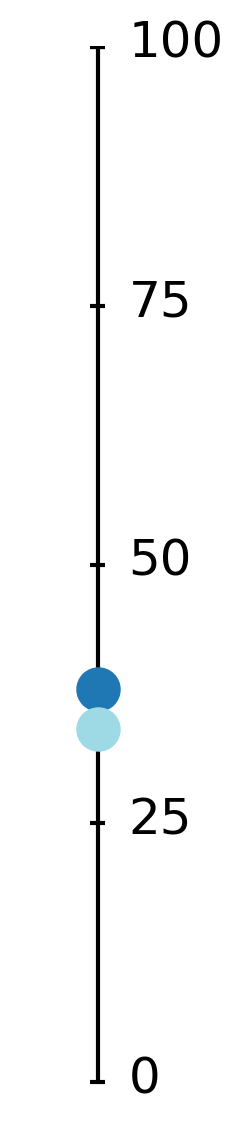

In [50]:
# set up the figure
fig = plt.figure(figsize = (1,7), dpi = 200)
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

# draw lines
ymin = 0
ymax = 100
ax.set_ylim(ymin-2,ymax+0.1)

x = 5
height = 1
ax.set_xlim(0,10)

plt.vlines(x, ymin, ymax, color = 'k')
plt.hlines(ymin, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax//4, x - height / 2., x + height / 2., color = 'k')
plt.hlines(ymax//2, x - height/2, x + height/2, color = 'k')
plt.hlines(3*ymax//4, x - height / 2, x + height / 2, color = 'k')

# draw a point on the line
px = 4
for u in unique_clusters:
    health_val = cluster_data.loc[cluster_data.cluster == u].containment_health.values[0]
    cluster_color = color_dict[u]
    plt.plot(x, health_val, marker = 'o', ms = 15, color = cluster_color, linewidth = 10)


# add numbers
plt.text(x+2, ymin - 1, '0')#, horizontalalignment='right')
plt.text(x+2, ymax - 1, '100')#, horizontalalignment='left')
plt.text(x+2, ymax//4 - 1, '25')#, horizontalalignment='left')
plt.text(x+2, ymax//2 - 1, '50')#, horizontalalignment='left')
plt.text(x+2, 3*ymax//4 - 1, '75')#, horizontalalignment='left')

plt.axis('off')
plt.show()

## Change over time

In [45]:
size_average = []
geographic_average = []
times = list(range(data.shape[0]))
for t in times:
    time = times[t]
    segs = get_segments(time, (0,1000))
    seg_clusters = segment_clusters(segs)

    size = 0
    geo = 0
    for c in seg_clusters:
        cdata = cluster_data.loc[cluster_data.cluster == c]
        size += cdata.cluster_size.values[0]
        geo += cdata.diameter_miles.values[0]
        
    size /= len(seg_clusters)
    geo /= len(seg_clusters)
    size_average.append(size)
    geographic_average.append(geo)

Text(0, 0.5, 'Average cluster size')

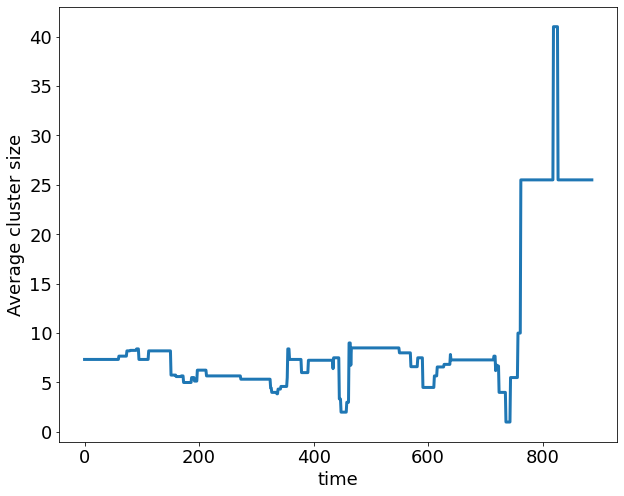

In [46]:
fig,ax = plt.subplots(figsize = (10,8))
ax.plot(size_average, linewidth = 3)
ax.set_xlabel('time')
ax.set_ylabel('Average cluster size')

Text(0, 0.5, 'Average cluster geographic distance')

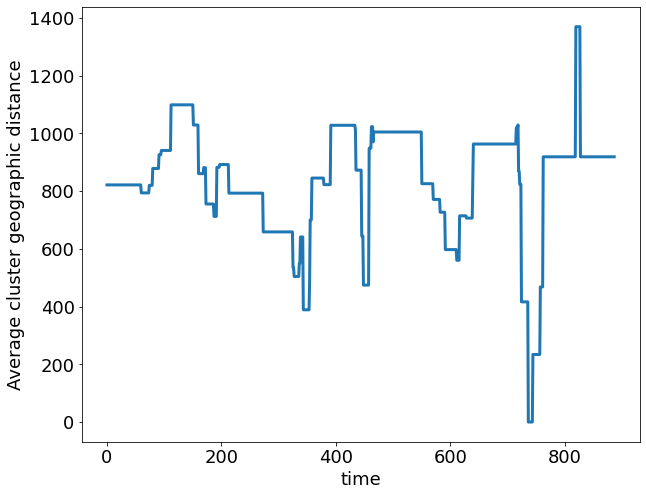

In [47]:
fig,ax = plt.subplots(figsize = (10,8))
ax.plot(geographic_average, linewidth = 3)
ax.set_xlabel('time')
ax.set_ylabel('Average cluster geographic distance')

## Comparison to random clusterings

In [48]:
# Non - random clusterings for baseline
# Unimodal, SIR, and wavefinder segmentation methods
uni_analysis = pd.read_csv('../../batch3/data/state/state_uni_analysis.csv', index_col = 0)
uni_filter = uni_analysis.loc[uni_analysis.cluster_size >= 2]

sir_analysis = pd.read_csv('../../batch3/data/state/state_sir_analysis.csv', index_col = 0)
sir_filter = sir_analysis.loc[sir_analysis.cluster_size >= 2]

wav_analysis = pd.read_csv('../../batch3/data/state/state_wav_analysis.csv', index_col = 0)
wav_filter = wav_analysis.loc[wav_analysis.cluster_size >= 2]

In [49]:
wav_filter

,cluster,cluster_size,cost,silhouette_score,total_points,explained_variance,diameter_miles,diameter_density,containment_health,avg_infections
1,1,2,0.003264,0.806057,173,8.209842e+04,688.616431,277.200000,3.196934,12.087336
2,2,6,0.012430,0.806057,707,6.383195e+06,1437.250321,49.560000,4.948685,90.543412
3,3,17,0.013556,0.806057,4349,1.479078e+07,1115.459109,450.363235,4.585915,49.579839
4,4,5,0.016138,0.806057,630,3.300094e+05,119.909798,397.060000,10.218144,13.525391
5,5,6,0.017710,0.806057,1783,9.367349e+05,432.398548,439.720000,9.834148,24.210014
6,6,31,0.018551,0.806057,4449,2.625617e+07,1277.931323,172.665806,7.125297,67.583332
7,7,29,0.027552,0.806057,12569,8.164399e+06,1359.217390,168.068966,9.061315,20.537573
8,8,16,0.031389,0.806057,4580,2.880706e+06,1171.258265,339.949167,10.895687,29.692457
9,9,12,0.032447,0.806057,2090,9.693996e+05,1049.712539,118.213636,6.145796,14.829563
10,10,10,0.034483,0.806057,1178,3.854512e+05,1142.145535,444.946667,4.965375,16.806021


In [57]:
# For comparison:

#1) random clusterings after using each of the segmentation methdods
uni_rc_analysis = pd.read_csv('../../batch3/data/state/uni_rc_analysis.csv', index_col = 0)
uni_rc_filter = uni_rc_analysis.loc[uni_rc_analysis.cluster_size >= 2]
uni_rc_filter = uni_rc_filter.loc[uni_rc_filter.clustering <= 1000]

sir_rc_analysis = pd.read_csv('../../batch3/data/state/sir_rc_analysis.csv', index_col = 0)
sir_rc_filter = sir_rc_analysis.loc[sir_rc_analysis.cluster_size >= 2]
sir_rc_filter = sir_rc_filter.loc[sir_rc_filter.clustering <= 1000]

wav_rc_analysis = pd.read_csv('../../batch3/data/state/wav_rc_analysis.csv', index_col = 0)
wav_rc_filter = wav_rc_analysis.loc[wav_rc_analysis.cluster_size >= 2]
wav_rc_filter = wav_rc_filter.loc[wav_rc_filter.clustering <= 1000]

#2) random segmentation followed by clique clustering
rs_analysis = pd.read_csv('../../batch3/data/state/random_segment_clusters.csv', index_col = 0)
rs_filter = rs_analysis.loc[rs_analysis.cluster_size >= 2]

#3) random segmentation followed by random clustering
rc_rs_analysis = pd.read_csv('../../batch3/data/state/random_segment_random_clusters.csv', index_col = 0)
rc_rs_filter = rc_rs_analysis.loc[rc_rs_analysis.cluster_size >= 2]

In [118]:
compare = 'silhouette_score'

In [119]:
# random clusterings average of clusters
rc_clusterings = uni_rc_filter.clustering.value_counts()
uni_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in uni_rc_filter.index:
    idx = rc_dict[uni_rc_filter.loc[row, 'clustering']]
    uni_rc_means[idx] += uni_rc_filter.loc[row, compare]
    
uni_rc_means = uni_rc_means / rc_clusterings.to_numpy()

In [120]:
# random clusterings average of clusters
rc_clusterings = sir_rc_filter.clustering.value_counts()
sir_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in sir_rc_filter.index:
    idx = rc_dict[sir_rc_filter.loc[row, 'clustering']]
    sir_rc_means[idx] += sir_rc_filter.loc[row, compare]
    
sir_rc_means = sir_rc_means / rc_clusterings.to_numpy()

In [121]:
# random clusterings average of clusters
rc_clusterings = wav_rc_filter.clustering.value_counts()
wav_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in wav_rc_filter.index:
    idx = rc_dict[wav_rc_filter.loc[row, 'clustering']]
    wav_rc_means[idx] += wav_rc_filter.loc[row, compare]
    
wav_rc_means = wav_rc_means / rc_clusterings.to_numpy()

In [122]:
# random segments average of clusters
rs_clusterings = rs_filter['sample'].value_counts()
rs_means = np.zeros(len(rs_clusterings))
rs_dict = {rs_clusterings.index[i]:i for i in range(len(rs_clusterings))}
for row in rs_filter.index:
    idx = rs_dict[rs_filter.loc[row, 'sample']]
    rs_means[idx] += rs_filter.loc[row, compare]
    
rs_means = rs_means / rs_clusterings.to_numpy()

In [123]:
# random segments average of clusters
rc_rs_clusterings = rc_rs_filter['sample'].value_counts()
rc_rs_means = np.zeros(len(rc_rs_clusterings))
rc_rs_dict = {rc_rs_clusterings.index[i]:i for i in range(len(rc_rs_clusterings))}
for row in rc_rs_filter.index:
    idx = rc_rs_dict[rc_rs_filter.loc[row, 'sample']]
    rc_rs_means[idx] += rc_rs_filter.loc[row, compare]
 
rc_rs_means = rc_rs_means / rc_rs_clusterings.to_numpy()

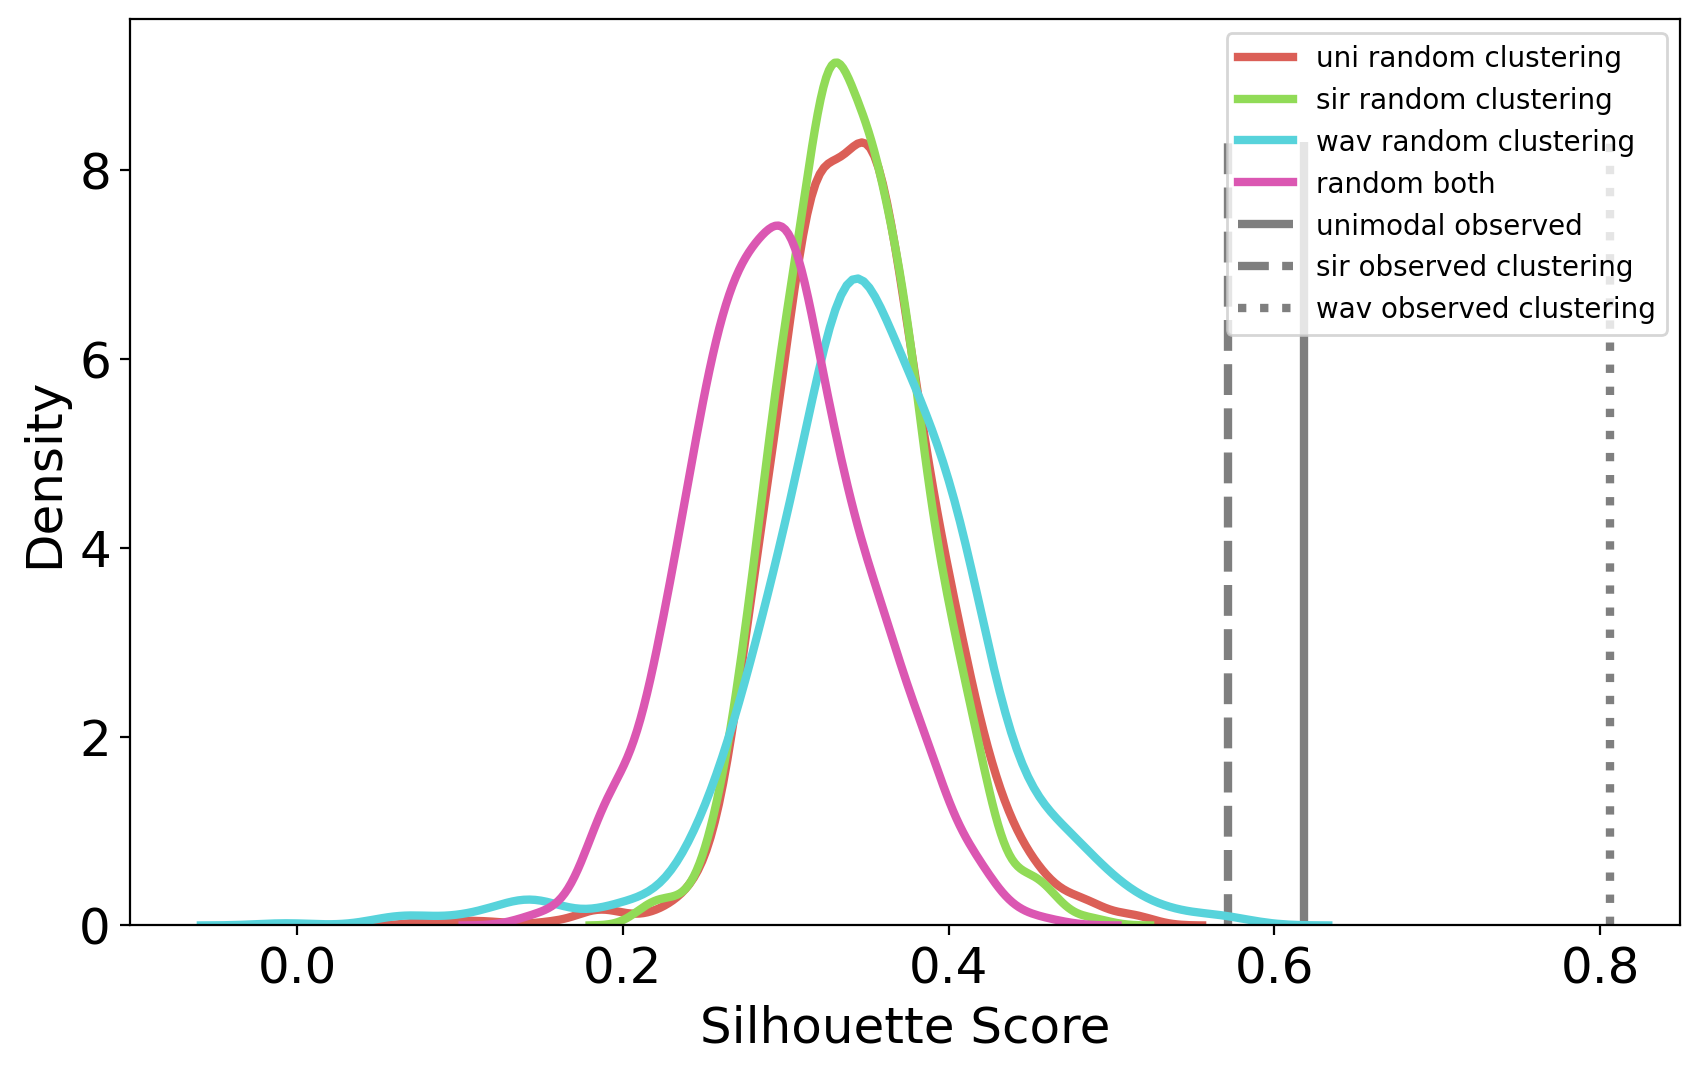

In [125]:
fig,ax = plt.subplots(figsize = (10,6), dpi = 200)
pal = sns.color_palette("hls", 8)
s1 = sns.kdeplot(uni_rc_means, ax = ax, color = pal[0], label = 'uni random clustering', linewidth = 3)
s2 = sns.kdeplot(sir_rc_means, ax = ax, color = pal[2], label = 'sir random clustering', linewidth = 3)
s3 = sns.kdeplot(wav_rc_means, ax = ax, color = pal[4], label = 'wav random clustering', linewidth = 3)
#s4 = sns.kdeplot(rs_means, ax = ax, color = pal[6], label = 'random segments')
s5 = sns.kdeplot(rc_rs_means, ax = ax, color = pal[7], label = 'random both', linewidth = 3)

_,y = ax.lines[0].get_data()
max_height = np.max(y)
ax.vlines(x = uni_filter.loc[:,compare].mean(), ymin = 0, ymax = max_height, linestyle = 'solid', color = 'k', 
          linewidth = 3, label = 'unimodal observed', alpha = 0.5)

ax.vlines(x = sir_filter.loc[:,compare].mean(), ymin = 0, ymax = max_height, linestyle = '--', color = 'k', 
          linewidth = 3, label = 'sir observed clustering', alpha = 0.5)

ax.vlines(x = wav_filter.loc[:,compare].mean(), ymin = 0, ymax = max_height, linestyle = 'dotted', color = 'k', 
          linewidth = 3, label = 'wav observed clustering', alpha = 0.5)

ax.set_xlabel('Silhouette Score')


plt.legend(fontsize = 10)

### Containment Health

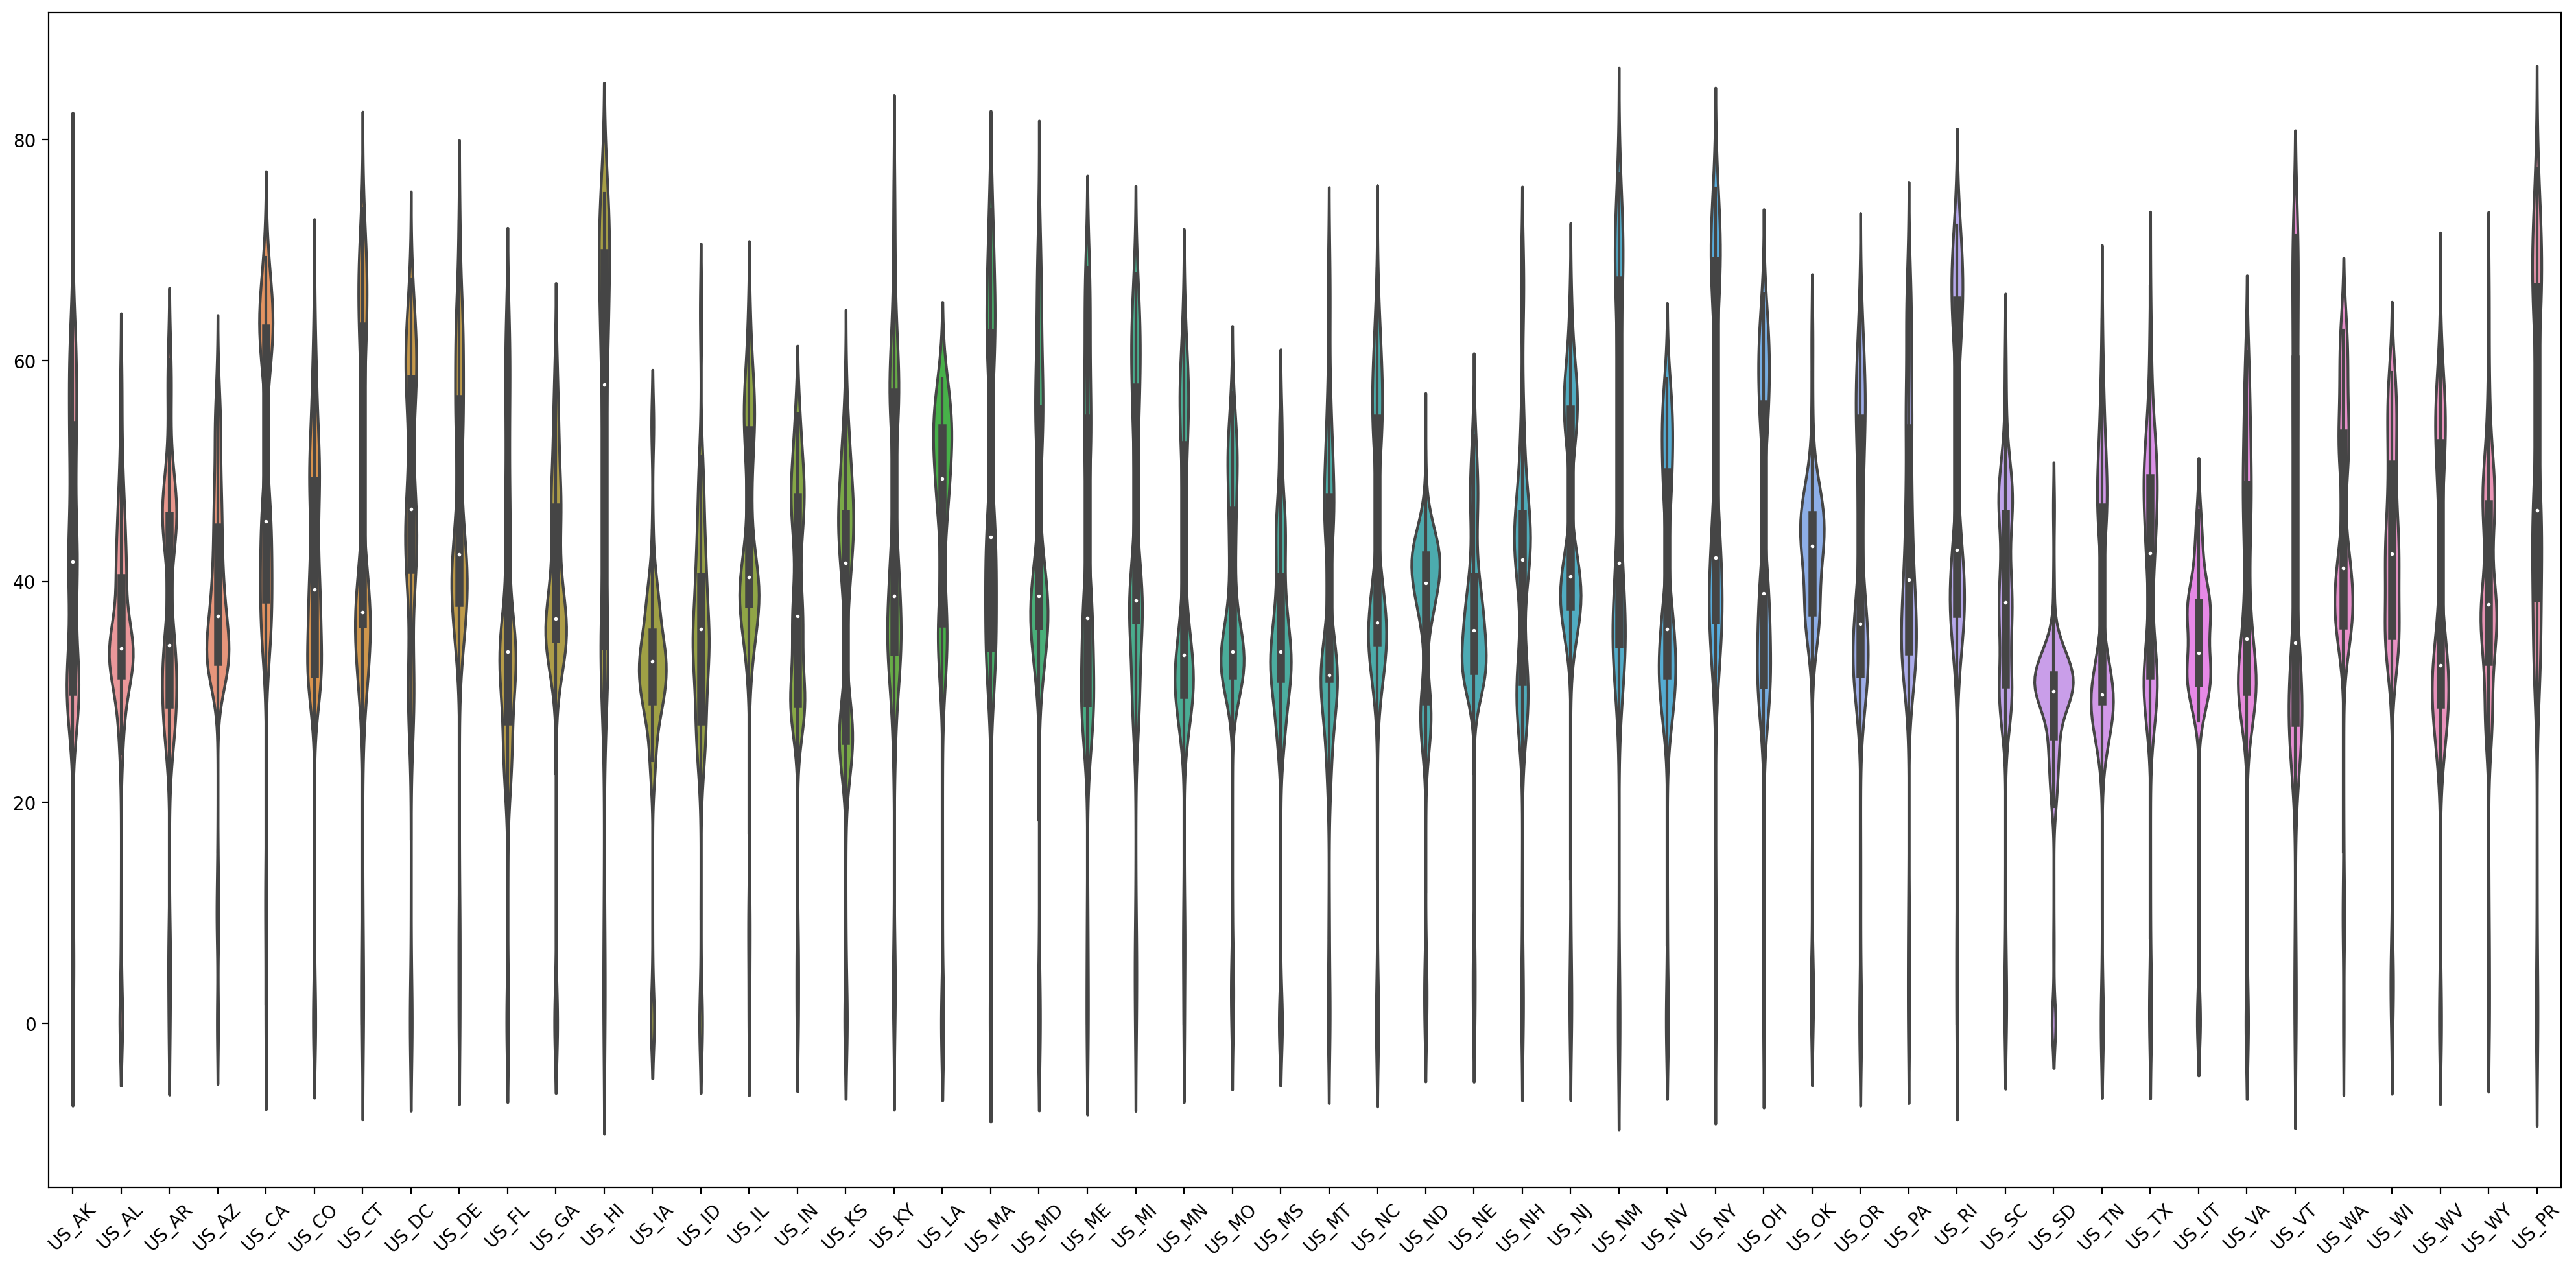

In [74]:
fig,ax = plt.subplots(dpi = 200, figsize = (25,12))
sns.violinplot(data = containment_health, ax = ax)
ax.tick_params(axis='x', labelrotation=45)

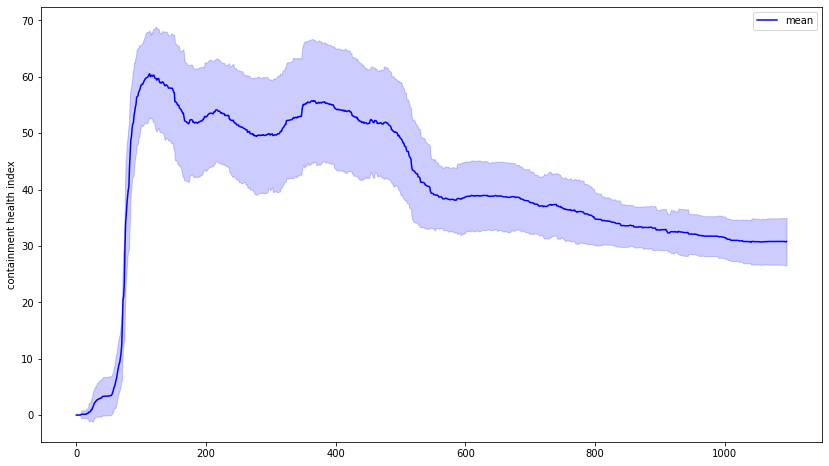

In [75]:
fig,ax = plt.subplots(figsize = (14,8))
x = range(len(containment_health.index))
mean = containment_health.mean(axis = 1)
std = containment_health.std(axis = 1)

ax.plot(x, mean, 'b-', label='mean')
ax.fill_between(x, mean - std, mean + std, color='b', alpha=0.2)
ax.set_ylabel('containment health index')
pos = [0,200,400,600,800,1000]
#ax.set_xticks(pos, [containment_health.index[i] for i in pos])
plt.legend()
plt.show()

In [76]:
health_segments = []
for seg in wpool.key_list:
    dname = seg[:5]
    times = wpool.times[seg]
    loc = containment_health.loc[:,dname]
    seg_loc = loc[times[0]:times[1]]
    health_segments.append(seg_loc.mean())

Text(0.5, 0, 'Containment Health Score')

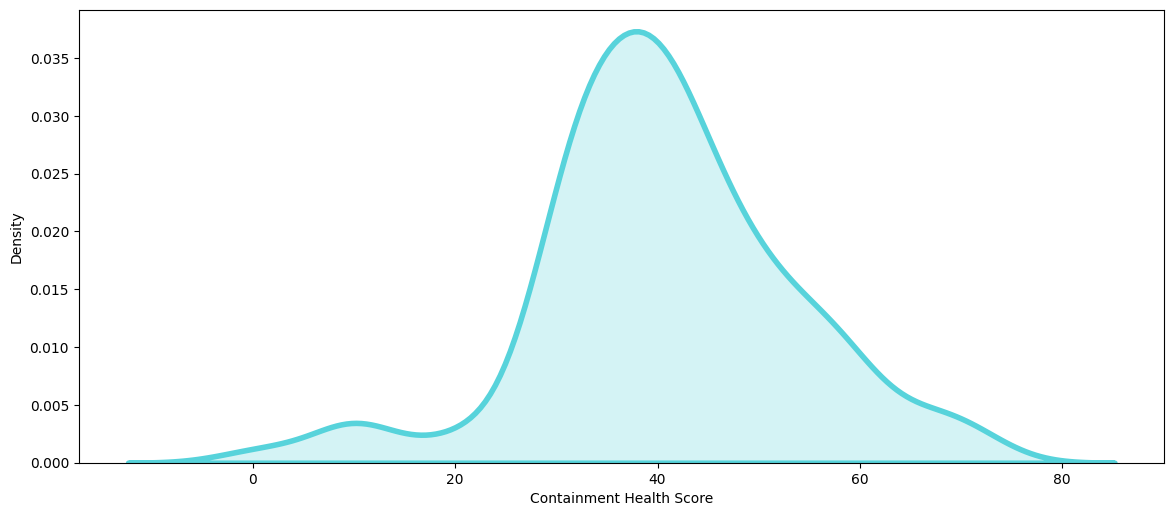

In [77]:
fig,ax = plt.subplots(figsize = (14,6), dpi = 100)
pal = sns.color_palette("hls", 8)
sns.kdeplot(health_segments, color = pal[4], linewidth = 4, fill = True)
ax.set_xlabel('Containment Health Score')

In [78]:
np.std(health_segments)

12.65661223624266

In [79]:
np.all(np.array(health_segments) >= 0)

True

### Older Code

In [ ]:
def knapsack(values, weights, W):
    n = len(values)
    dp = np.zeros((n + 1, W + 1))
    track = np.zeros((n + 1, W + 1))
    track[:] = np.nan

    # Build the DP table
    for i in range(1, n + 1):
        for w in range(1, W + 1):
            if weights[i - 1] <= w:
                if dp[i - 1, w] > dp[i - 1, w - weights[i - 1]] + values[i - 1]:
                    dp[i, w] = dp[i - 1, w]
                else:
                    dp[i, w] = dp[i - 1, w - weights[i - 1]] + values[i - 1]
                    track[i,w] = i - 1
            else:
                dp[i, w] = dp[i - 1, w]
                
    # retrace steps:
    i = n
    w = W
    item_selection = []
    while i > 0: 
        select = track[i,w]
    
        if not np.isnan(select):
            select = int(select)
            item_selection.append(select)
            w = w - weights[select]
            
        i -= 1
        
    return item_selection, dp[n, W]

In [ ]:
integer_weights = (np.round(cluster_data_nons.cost.to_numpy(), 2) * 100).astype(int)
items, value = knapsack(cluster_data_nons.total_points.to_numpy(), integer_weights, 70 * 100)

In [ ]:
loc1 = 'US_ID_1'
loc2 = 'US_GA_1'
times1 = wpool.times[loc1]
times2 = wpool.times[loc2]
#time_union = (min(times1[0], times2[0]), max(times1[1], times2[1]))
#x = data.loc[:,loc1[:-2]].to_numpy()[time_union[0]:time_union[1]]
#y = data.loc[:,loc2[:-2]].to_numpy()[time_union[0]:time_union[1]]
x = data.loc[:,loc1[:-2]].to_numpy()[times1[0]:times1[1]]
y = data.loc[:,loc2[:-2]].to_numpy()[times2[0]:times2[1]]
x = x.copy()
y = y.copy()
normy = max(x.max(), y.max())    
if normy != 0:
    x /= normy
    y /= normy

In [ ]:
def d(x,y):
    return np.linalg.norm(x-y)

mp = [1,1,1]
ap = [0,0,0]
cost, align, C= wc.dtw(x, y, distance = d, mult_penalty = mp, add_penalty = ap)

In [ ]:
longer = max(len(x), len(y))
shorter = min(len(x), len(y))
time_norm = longer + (5 - 1)*shorter
cost/time_norm

In [ ]:
# greedily select a new time point for optimal set coverage
# specifically, find the cluster which maximizes the cost / (# new points covered) ratio
# alternatively maximizes the cost / (new variance explained) ratio

def greedy_select_one(times, items_covered = set()):    
    best = np.inf
    best_time = None
    best_items_covered = []
    
    for t in range(len(times)):
        time = times[t]
        segs = get_segments(time)
        seg_clusters = segment_clusters(segs)
        
        cost = 0
        new_items_covered = []
        new_times_covered = []
        for c in seg_clusters:
            cdata = cluster_data.loc[cluster_data.cluster == c]
            cost += cdata.cost.values[0]
            
            cluster_items_covered = []
            cluster_times_covered = []
            for l in cliquer.C[c]:
                l_name = wpool.key_list[l]
                l_times = wpool.times[l_name]
                
                for ti in range(l_times[0], l_times[1]):
                    cluster_items_covered.append((ti,l))
                    cluster_times_covered.append(ti)

            new_items_covered.append(set(cluster_items_covered))
            new_times_covered.append(set(cluster_times_covered))
            
        
        union_cover = set.union(*new_items_covered)
        #print(union_cover)
        intersect = set.intersection(*new_times_covered)
        #print(intersect)
        #print()
        
        if len(intersect) != 0:
            cost = cost/len(intersect)
        else:
            cost = np.inf
            
        new_cover = union_cover - items_covered
        
        if len(new_cover) != 0:
            score = cost #/len(new_cover)
        else:
            score = np.inf
            
        if score < best:
            best = score
            best_time = times[t]
            best_items_covered = new_cover
    
    
    return best, best_time, best_items_covered 


# greedily select k time points to cover the most of the data 
# (set cover approximation algorithm)

def greedy_set_cover(k, times):
    time_select = []
    total_points_covered = 0
    #all_clusters = set(range(len(cliquer.C)))
    #clusters_covered = set()
    all_points = set([(i,j) for i in range(data.shape[0]) for j in range(data.shape[1])])
    data_points_covered = set()
    for i in range(k):
        new_value, new_time, new_cover = greedy_select_one(times, data_points_covered)        
        total_points_covered += new_value
        time_select.append(new_time)
        print(new_time)
        times.remove(new_time)
        #clusters_covered = clusters_covered.union(new_cover)
        data_points_covered = data_points_covered.union(new_cover)
        
        if data_points_covered == all_points:
            break
            
    return total_points_covered, time_select, data_points_covered

In [ ]:
total_points_covered, time_select, clusters_covered = greedy_set_cover(10, list(range(len(data))))